<a href="https://colab.research.google.com/github/Rachhh53/OnMart-Kafka-Neo4j-442/blob/main/Project_Phase_4_Requirements_Deliverables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-success">
    
    
# <center> Project Phase 4 </center>


<br>
    
</div>

In [1]:
!pip install plotly 
!pip install pystan==2.19.1.1 
!pip install statsmodels
!pip install prophet 
!pip install tensorflow
!pip install pmdarima 

     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 45 kB 963 kB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641813 sha256=c5335a2bc1f764064982113a0bce37f0b87fe10a5211b13734306a5dc680d857
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
     |████████████████████████████████| 462 kB 19.8 MB/s 
     |████████████████████████████████| 1.4 MB 30.7

In [3]:
import pandas as pd

import datetime
from datetime import datetime, date, timedelta
import time
from math import isnan
import numpy as np

import plotly
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

import pystan
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima
from pmdarima.arima.utils import ndiffs


import tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.python.util.deprecation as deprecation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings

deprecation._PRINT_DEPRECATION_WARNINGS = False
warnings.filterwarnings('ignore')


<div class="alert alert-info">

## <center> Requirements </center>


</div>


<div class="alert alert-warning">
1.	Create Customer-Friends-Product-Reviews graph database for OnMart

<br><br>
    
    
**Use PurchasesLog Dataset**
    
<br><br>
    

</div>

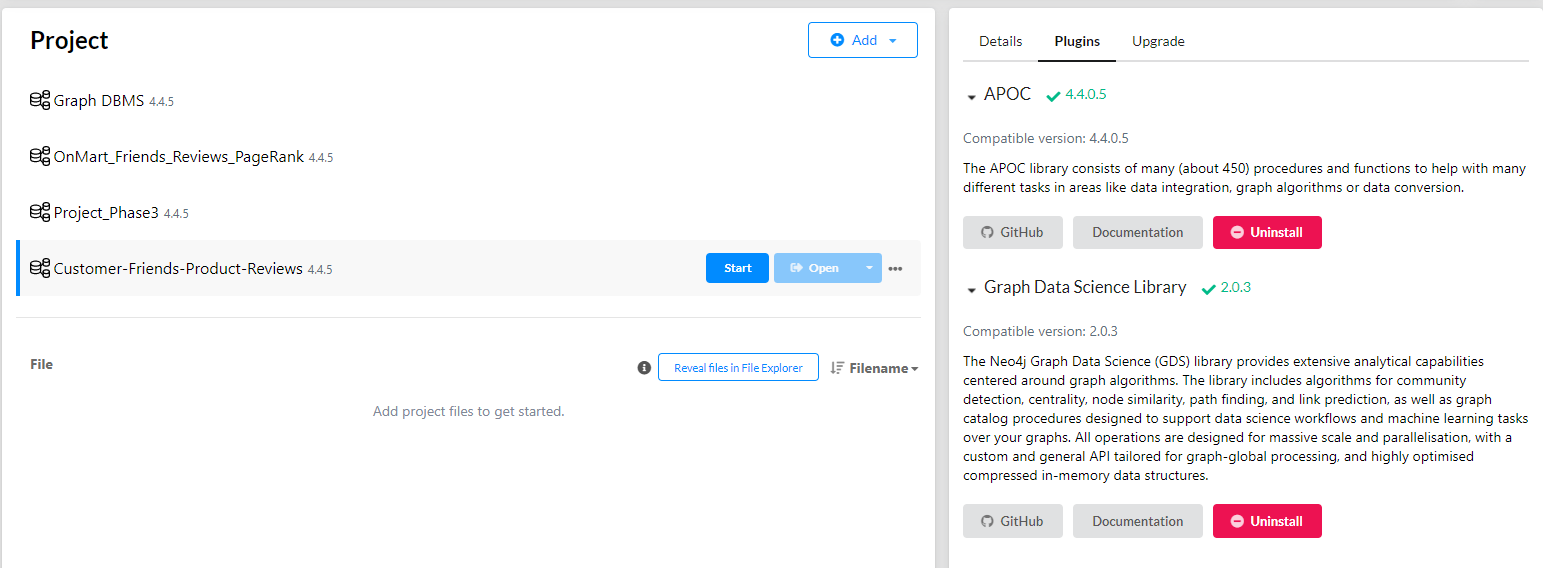

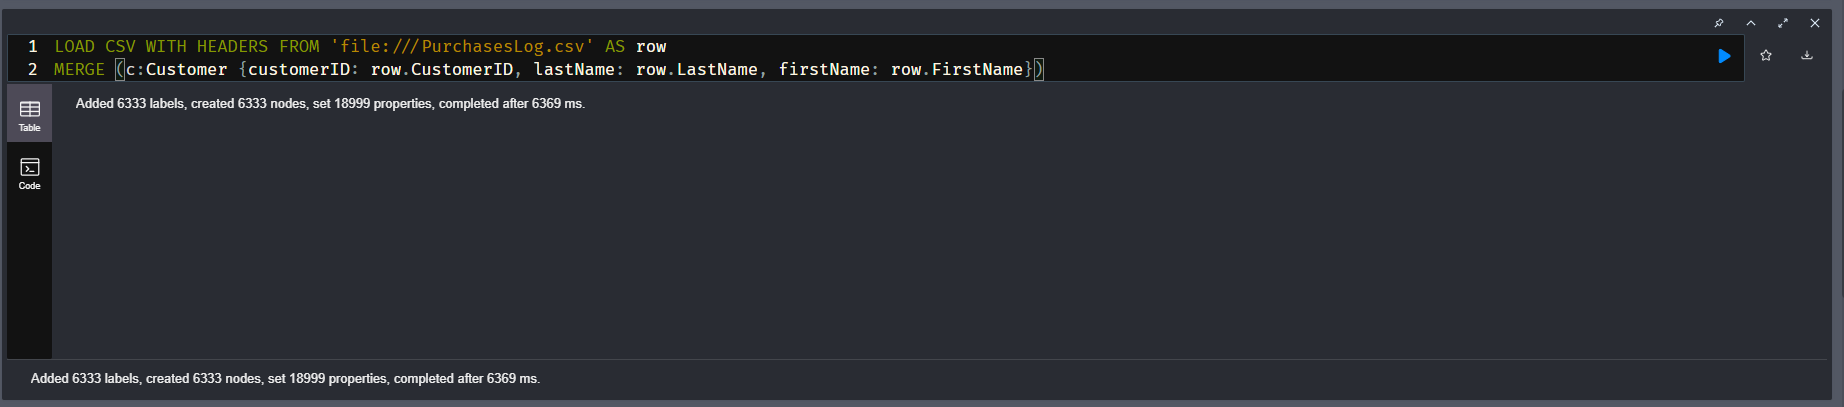

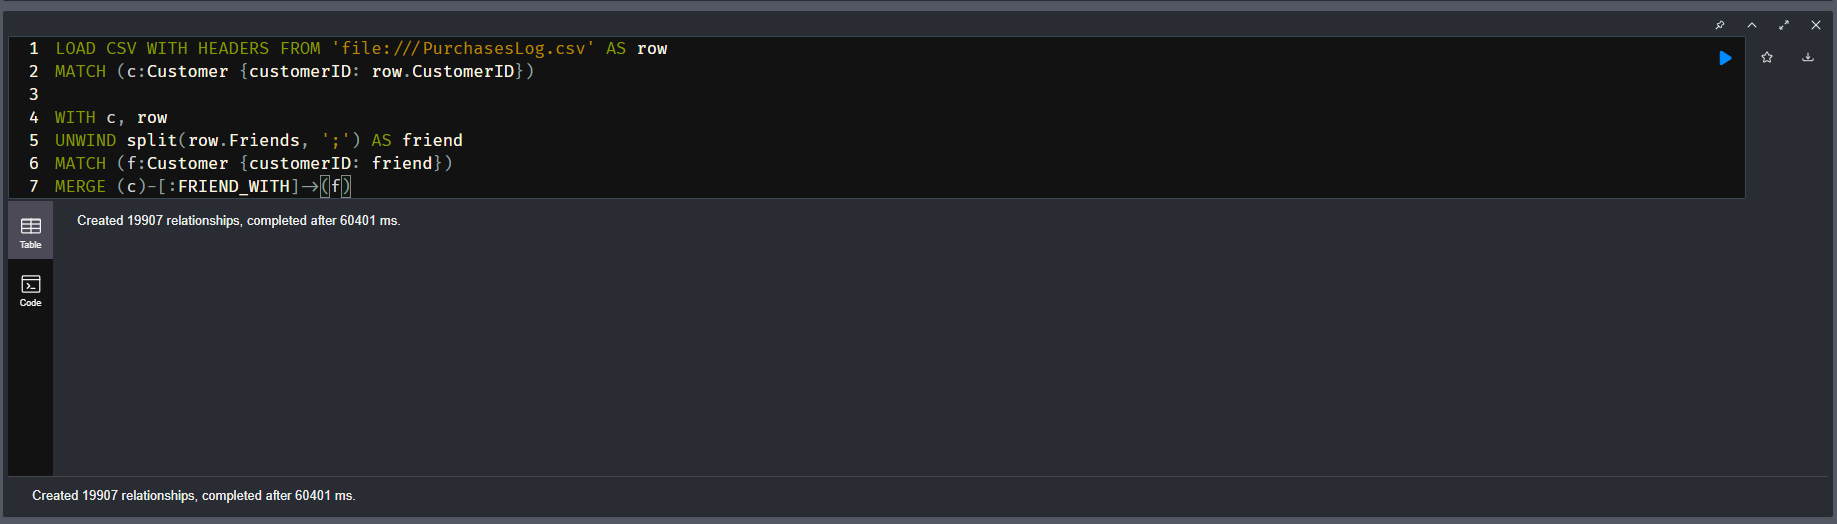

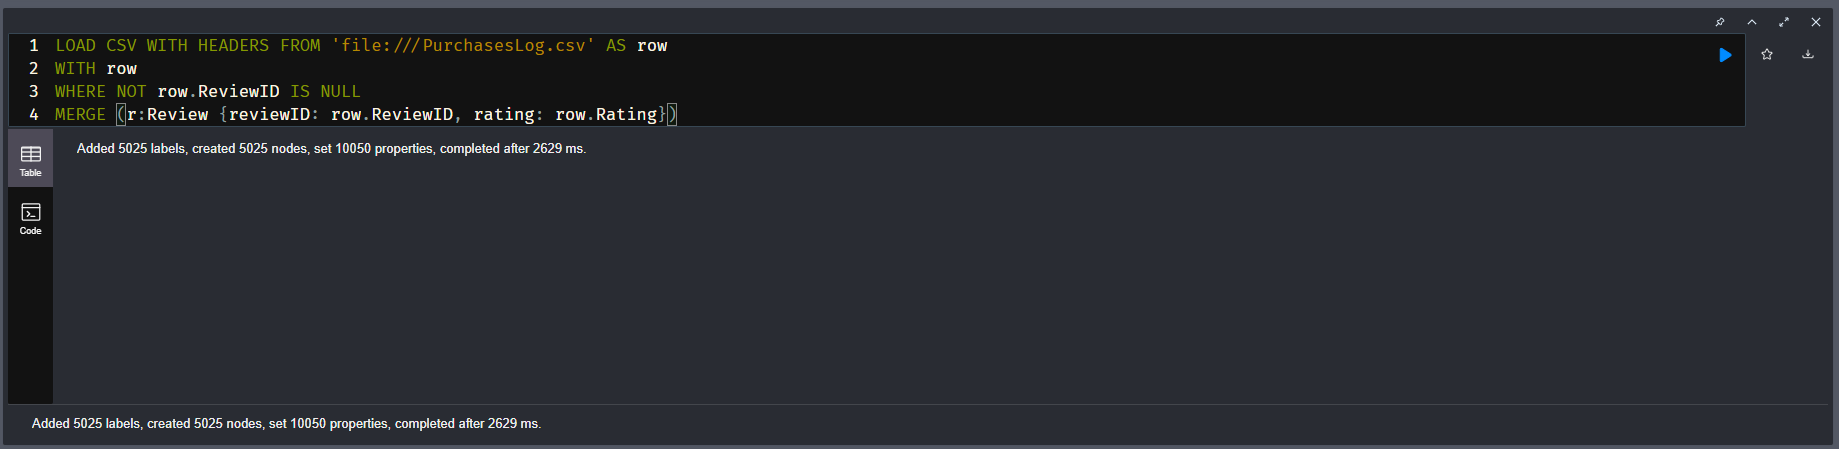

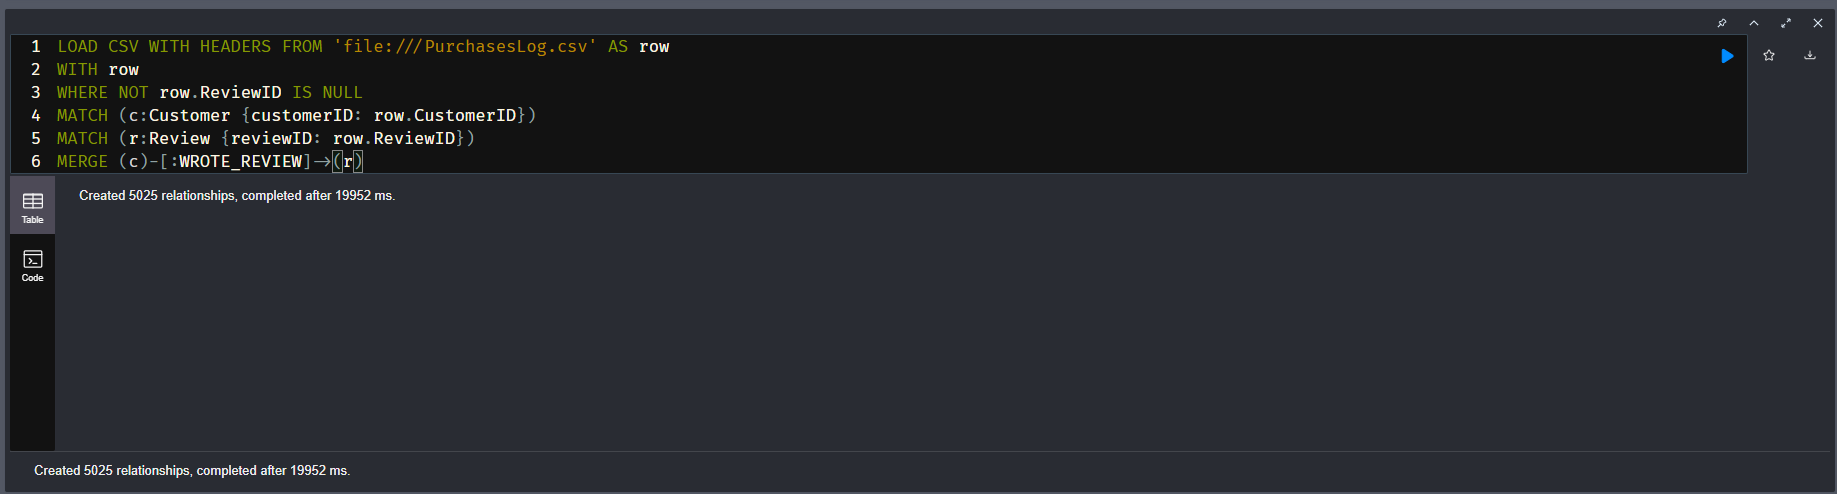

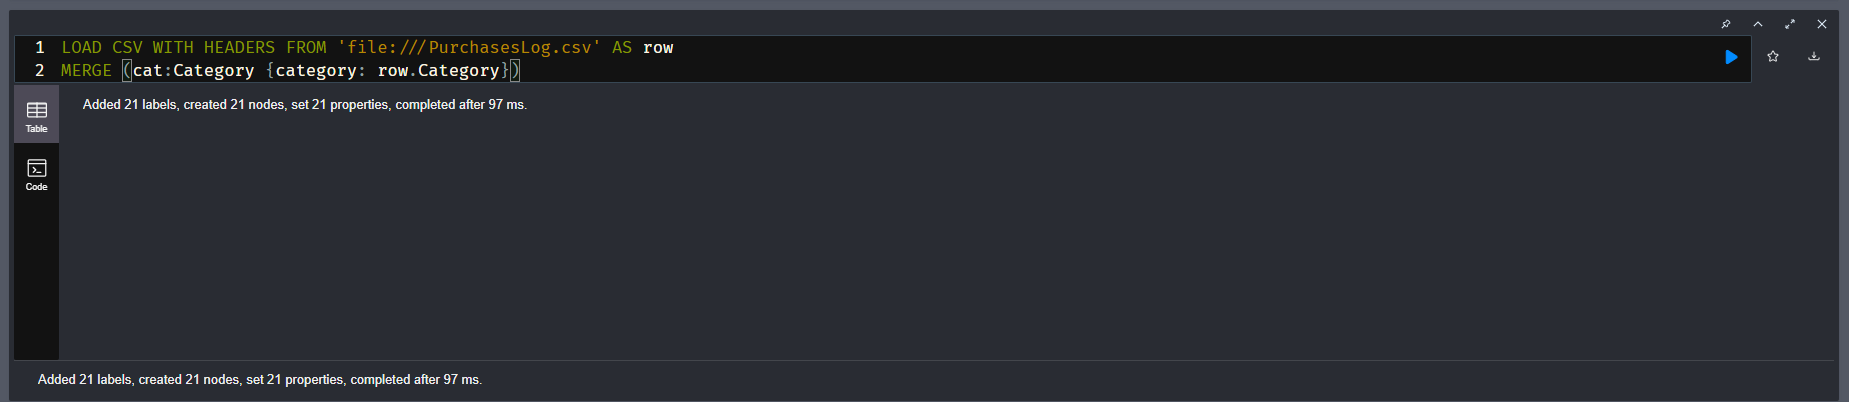

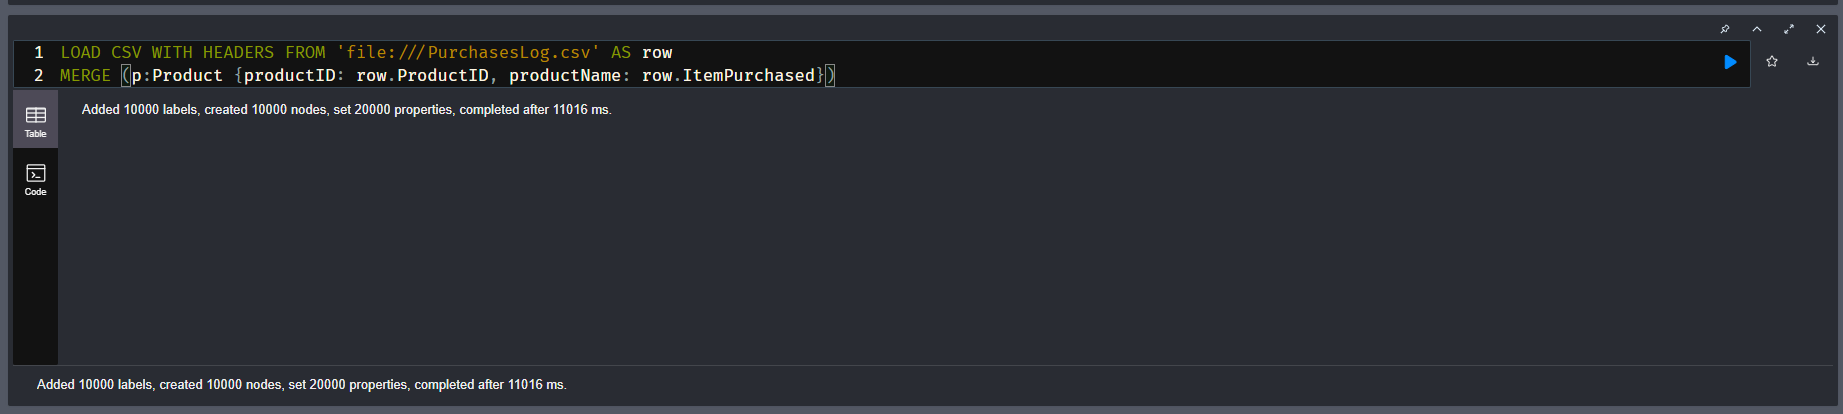

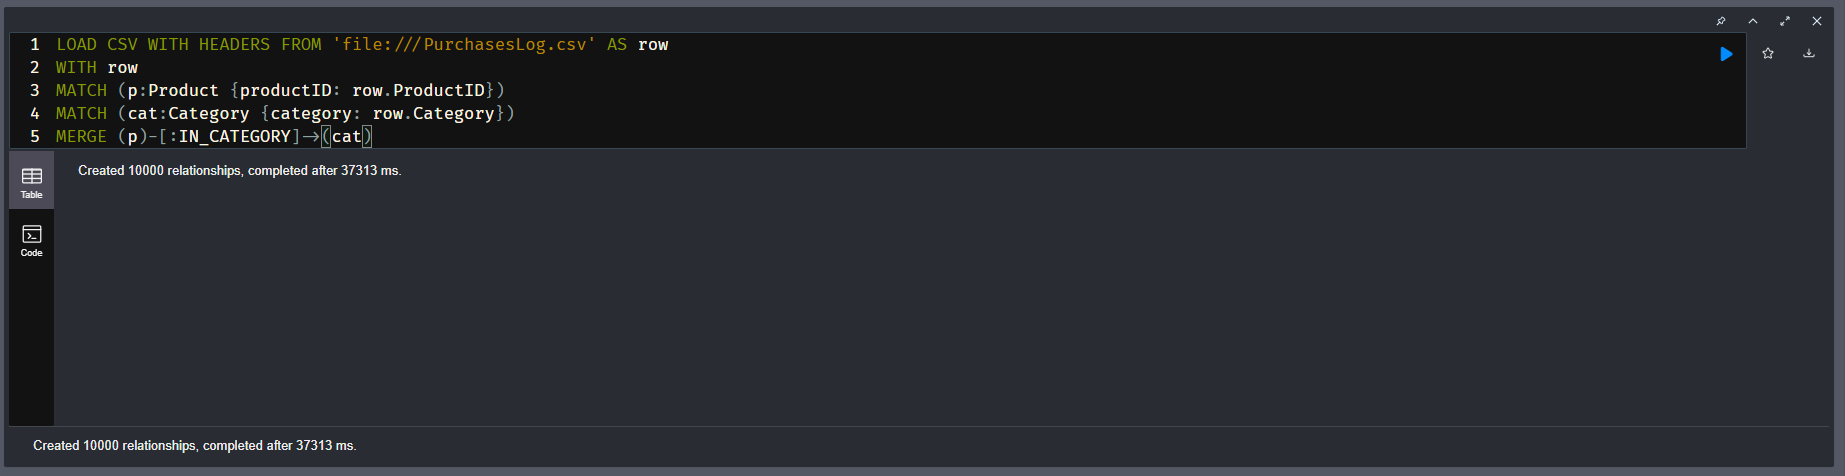

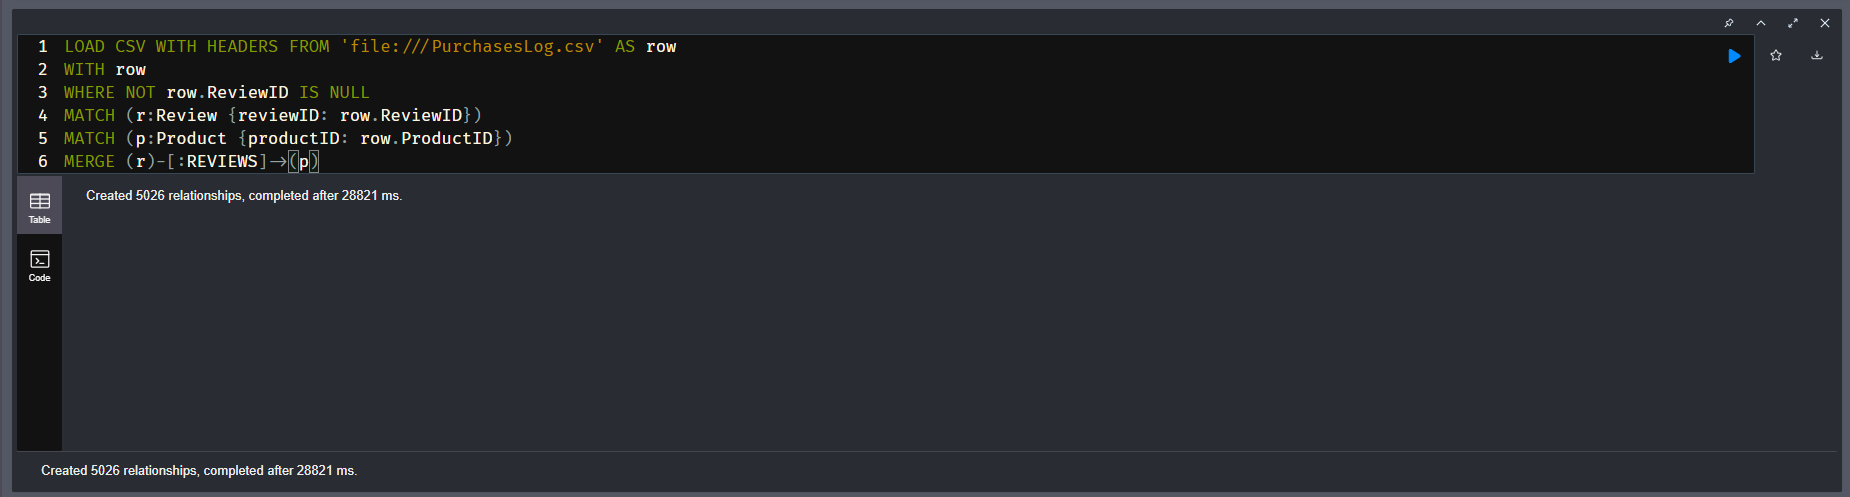

<div class="alert alert-warning">
2.	Use Google PageRank, and the graph database that you created above for customer reviews/ratings to find influential reviewers
    
<br><br>
    
    
**Use PurchasesLog Dataset**
    
<br><br>
    
    
    
</div>

In [1]:
# // My modifications for GDS version >= 2.0.3
# // Create Graph Projections
# CALL gds.graph.project.cypher(
# 'Customer-Friends-Product-Reviews',
# 'MATCH (c:Customer)-[:WROTE_REVIEW]->()-[:REVIEWS]->(p), (p)-[:IN_CATEGORY]->(:Category {category:"Tables"}) WITH c, count(*) AS reviews WHERE reviews >= 1 RETURN id(c) AS id',
# 'MATCH (c1:Customer)-[:WROTE_REVIEW]->()-[:REVIEWS]->(p), (p)-[:IN_CATEGORY]->(:Category {category:"Tables"}) MATCH (c1)-[:FRIEND_WITH]->(c2) RETURN id(c1) as source, id(c2) AS target',
# {validateRelationships: False}
# )
# YIELD graphName AS graph, nodeQuery, nodeCount AS nodes, relationshipQuery, relationshipCount AS rels

# // write tablesPageRank values to nodes
# CALL gds.pageRank.write('Customer-Friends-Product-Reviews',{
# maxIterations: 20,
# dampingFactor: 0.85,
# writeProperty: 'tablesPageRank'
# })
# YIELD nodePropertiesWritten, ranIterations
# RETURN nodePropertiesWritten, ranIterations

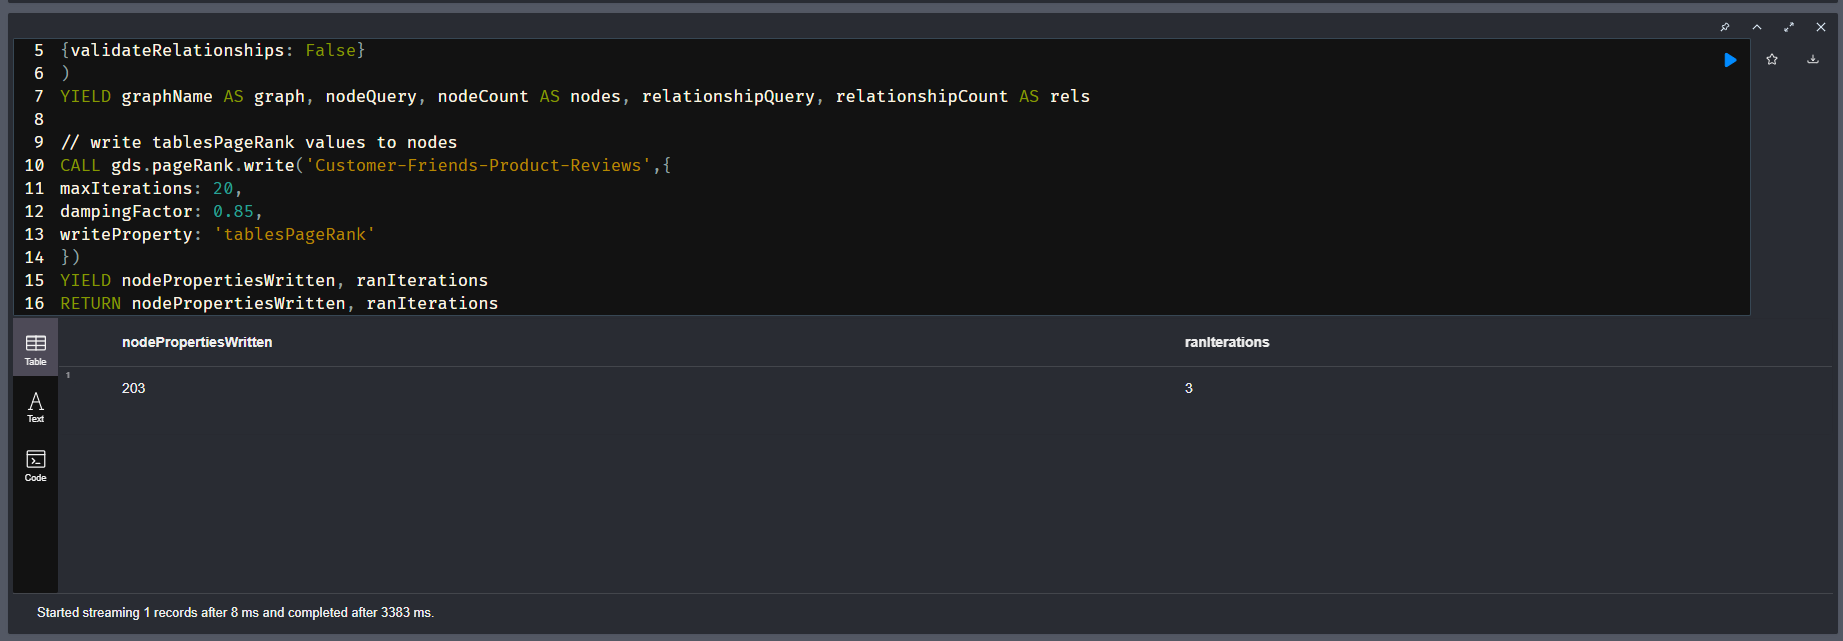

In [2]:
# // Compute percentiles
# MATCH (c:Customer)
# WHERE exists(c.tablesPageRank)
# return avg(c.tablesPageRank) as ave,
# apoc.math.round(percentileDisc(c.tablesPageRank, 0.5), 2) AS `50%`,
# apoc.math.round(percentileDisc(c.tablesPageRank, 0.75), 2) AS `75%`,
# apoc.math.round(percentileDisc(c.tablesPageRank, 0.90), 2) AS `90%`,
# apoc.math.round(percentileDisc(c.tablesPageRank, 0.95), 2) AS `95%`,
# apoc.math.round(percentileDisc(c.tablesPageRank, 0.99), 2) AS `99%`,
# apoc.math.round(percentileDisc(c.tablesPageRank, 1.0), 2) AS `100%`

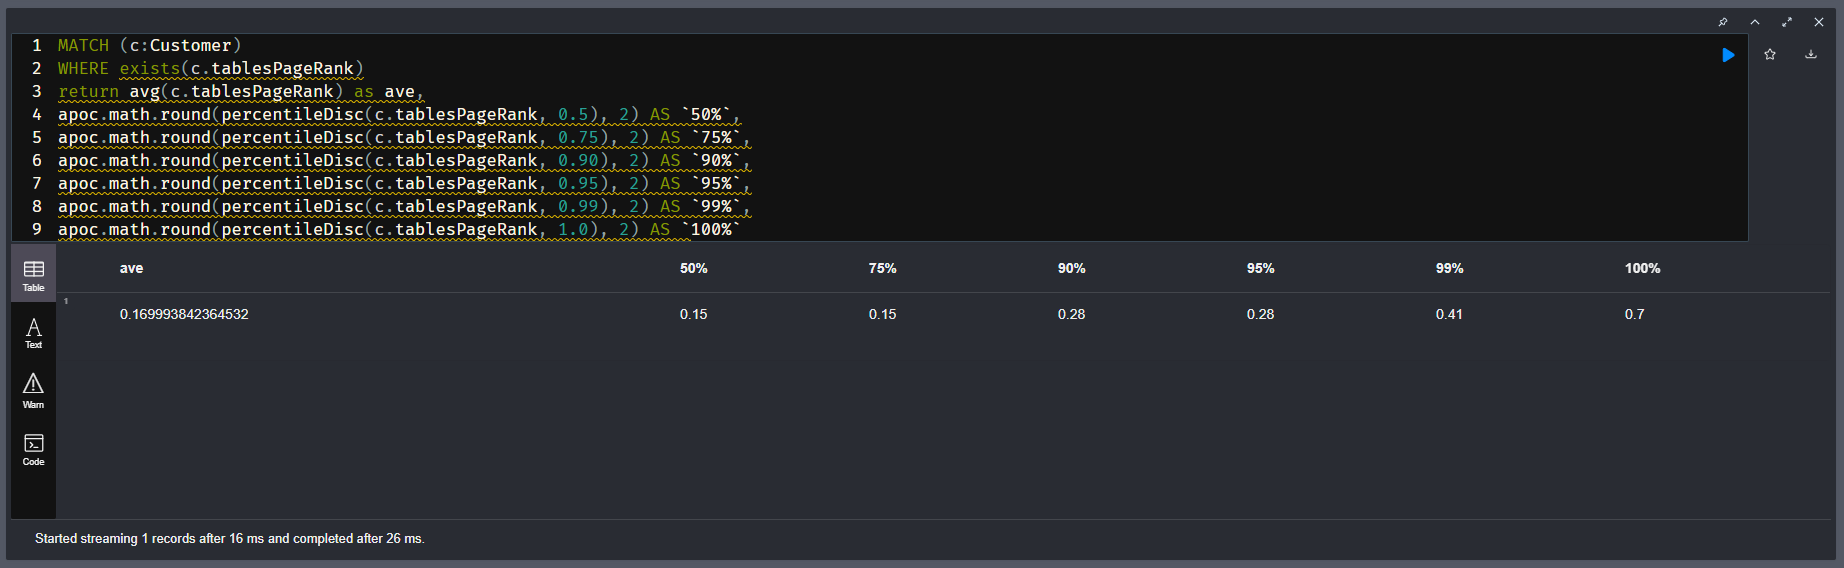

In [3]:
# MATCH (c:Customer)
# WHERE exists(c.tablesPageRank)
# MATCH (c:Customer)
# WHERE c.tablesPageRank > 0.16
# WITH c ORDER BY c.tablesPageRank DESC

# RETURN c.customerID AS customerID, c.lastName AS lastName,
#        c.tablesPageRank AS pageRank,
#        size((c)-[:WROTE_REVIEW]->()-[:REVIEWS]->()-[:IN_CATEGORY]->(:Category {category: 'Tables'})) AS TablesReviews,
#        size((c)-[:WROTE_REVIEW]->()) AS totalReviews,
#        size((c)-[:FRIEND_WITH]-()) AS friends;

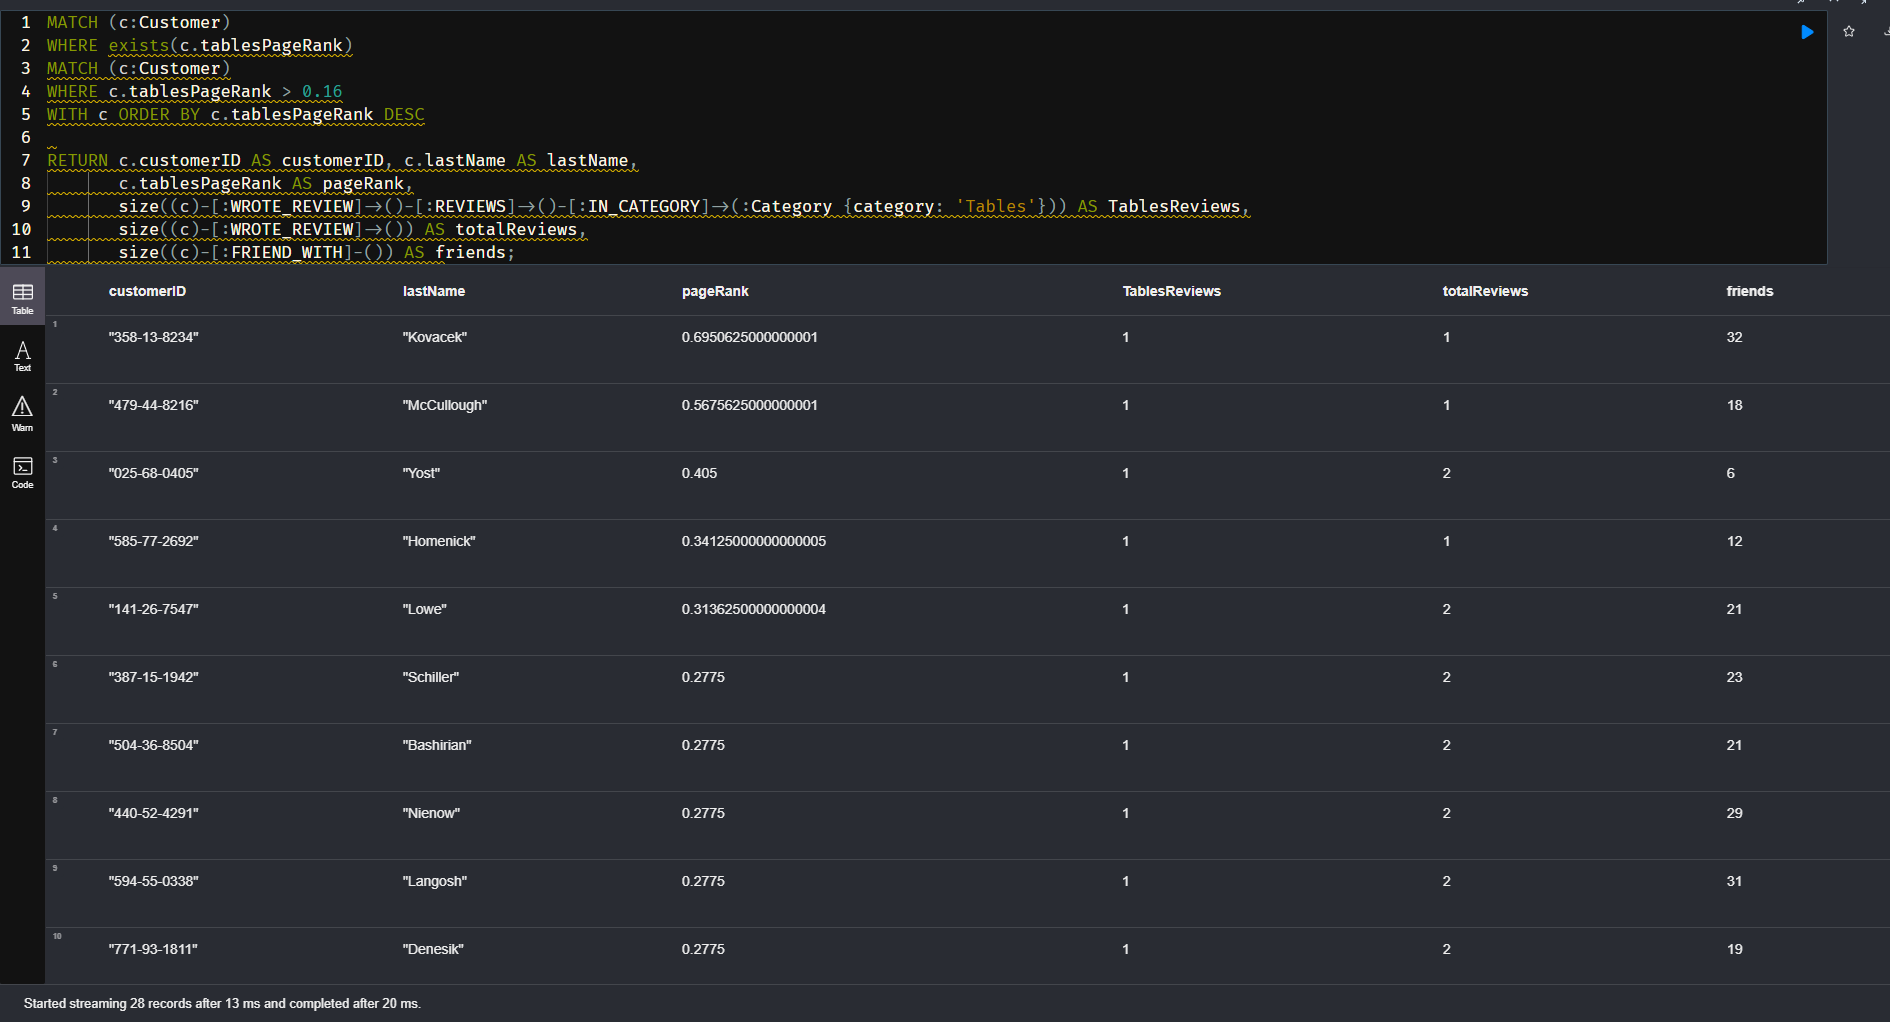

<div class="alert alert-warning">
3.	Use Betweenness Centrality and PageRank algorithms to find which OnMart superstore super-connected and influential reviewers  who can be used  to identify products from the Furniture department that it could use in a cross-promotion with the newly introduced Samsung TV  in the Electronics department
    
    
<br><br>
    
    
**Use PurchasesLog Dataset**
    
<br><br>
    
    
    
</div>

In [4]:
# //-------- Calculate betweenness and display percentile distribution of data  ----------------------------
# Match (c:Customer)
# Where exists((c)-[:WROTE_REVIEW]->())
# SET c:Reviewer;

# // So where Customer wrote review they are then given a label property Reviewer
# // Project graph into a Native Graph Projection (faster!!!) utilizing "Customer" and "Reviewer" nodes (though technically one is a subset of the other...)
# CALL gds.graph.project('Customer-Friends-Product-Reviewsb', ['Customer', 'Reviewer'], 'FRIEND_WITH')

# // Betweenness call
# CALL gds.betweenness.write('Customer-Friends-Product-Reviewsb',{writeProperty: "between"})
# YIELD centralityDistribution, nodePropertiesWritten
# RETURN centralityDistribution.min AS minimumScore, centralityDistribution.mean AS meanScore, nodePropertiesWritten

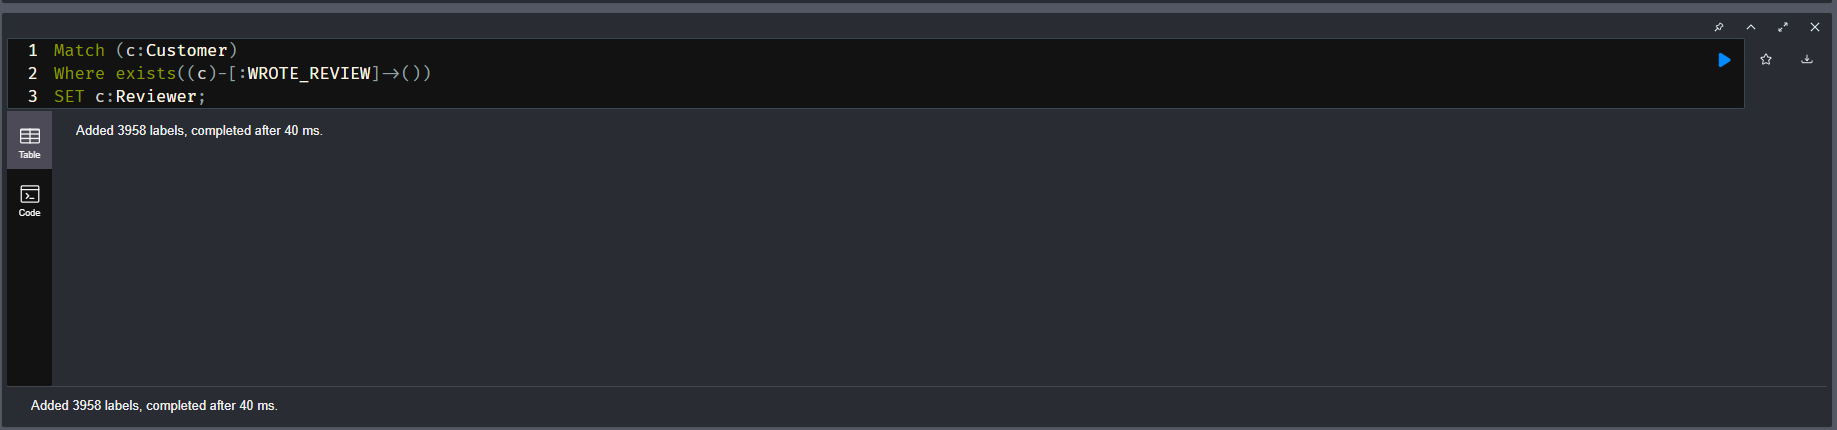

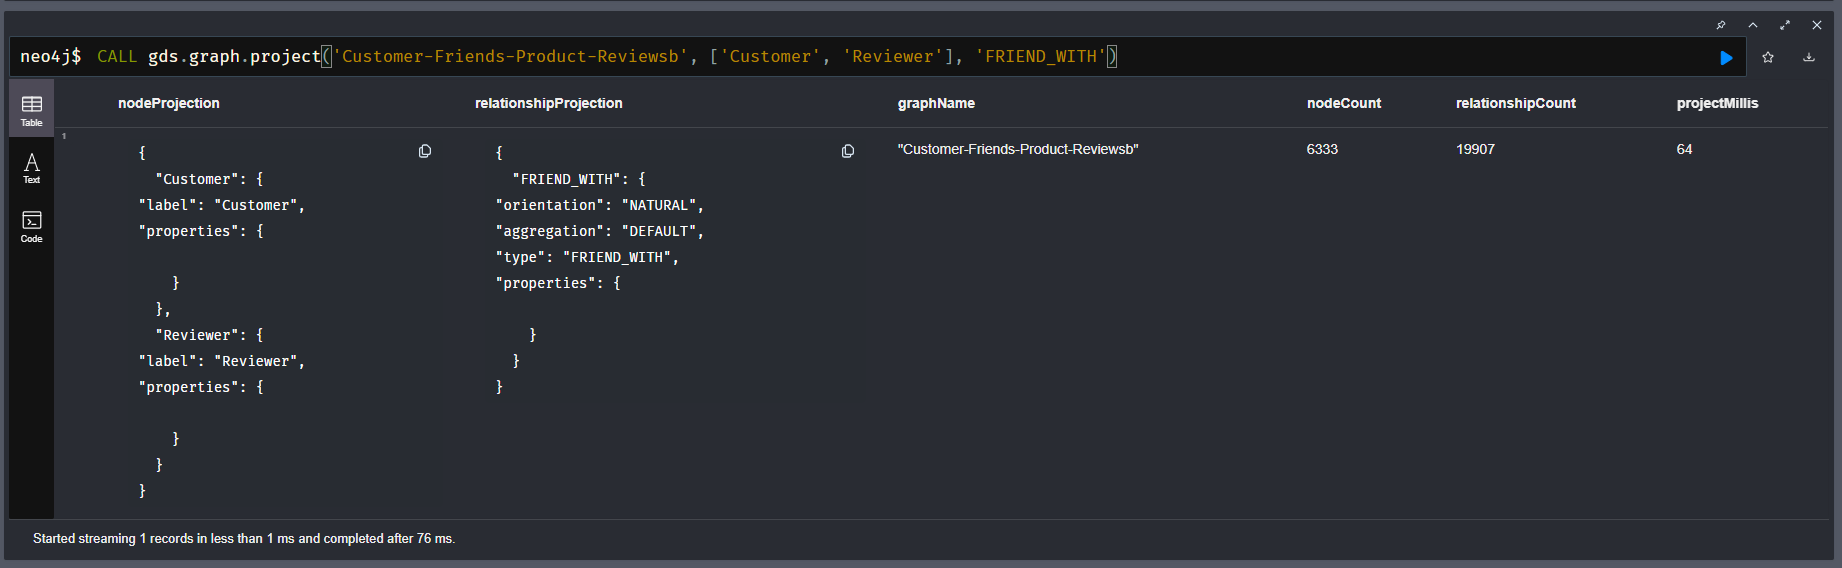

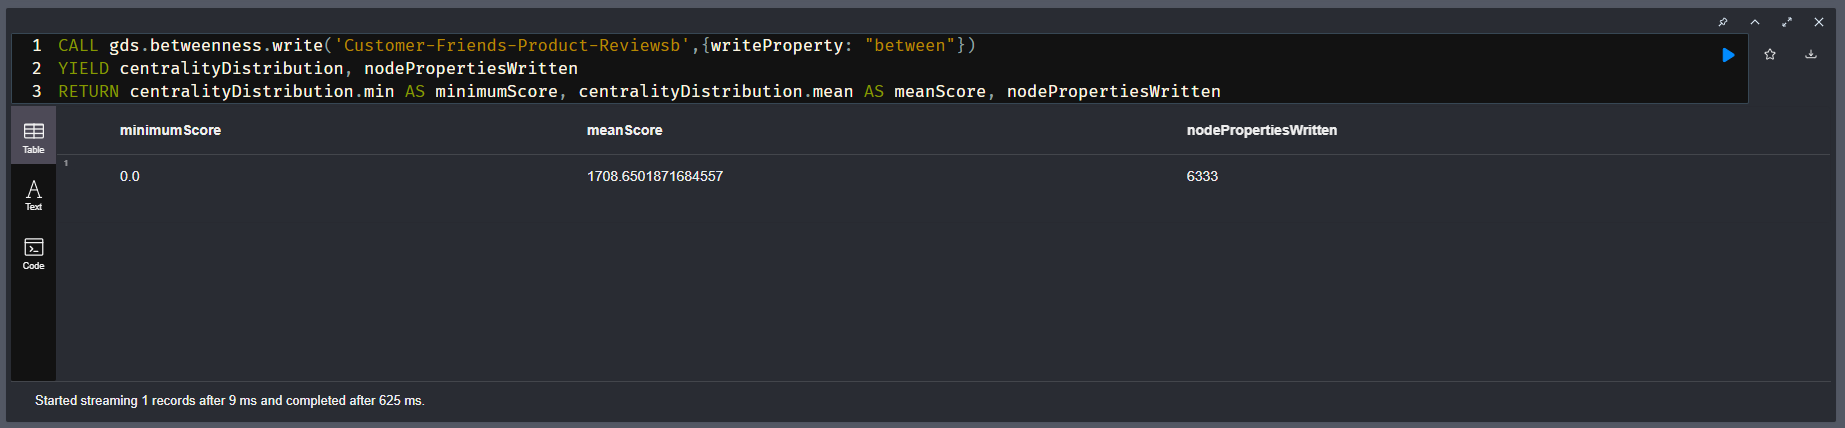

In [5]:
# /////////////////////////////////////////////////////////
# Match (c:Customer)
# Where exists(c.between)
# Return count(c.between) AS ind, avg(c.between) AS ave,
# toFloat(percentileDisc(c.between,0.5)) AS P50,
# toFloat(percentileDisc(c.between,0.75)) AS P75,
# toFloat(percentileDisc(c.between,0.90)) AS P90,
# toFloat(percentileDisc(c.between,0.95)) AS P95,
# toFloat(percentileDisc(c.between,0.99)) AS P99,
# toFloat(percentileDisc(c.between,1)) AS P100

# //------------- Display all betweenness scores for relevant customers (Please run this separately )-------------------------------------
# MATCH (c:Customer)-[:WROTE_REVIEW]->()-[:REVIEWS]->(:Product {productName: "Laptop Table - Multipurpose"})
# Where exists(c.between)
# WITH collect (distinct c.lastName) as userName,
#      toInteger(c.between) as betweenness,
#      c.tablesPageRank as pagerank,
#      size((c)-[:WROTE_REVIEW]->()-[:REVIEWS]->()-[:IN_CATEGORY]->(:Category {category: 'Tables'})) AS TablesReviews
# Return userName,
# betweenness, pagerank, TablesReviews order by betweenness desc
# //-----------------------------------------------------------------------------------------------------------------------------

# //-------- Cross-promot Tables product Laptop Table - Multipurpose with appliances

# MATCH (c:Customer)-[:WROTE_REVIEW]->()-[:REVIEWS]->(:Product {productName: "Laptop Table - Multipurpose"})
# WHERE c.between > 2.0
# WITH c ORDER BY c.between DESC LIMIT 50

# MATCH (c:Customer)-[:WROTE_REVIEW]->(review)-[:REVIEWS]->( product )
# WHERE ( product )-[:IN_CATEGORY]->(:Category {category: "Appliances"})

# WITH c, product , avg( toInteger(review.rating)) AS averageReviewRating, count(*) AS numberOfReviews
# WHERE numberOfReviews >= 1


# RETURN  c.lastName AS Customer, product.productName AS Product, averageReviewRating, numberOfReviews
# ORDER BY averageReviewRating DESC, numberOfReviews DESC
# LIMIT 10;

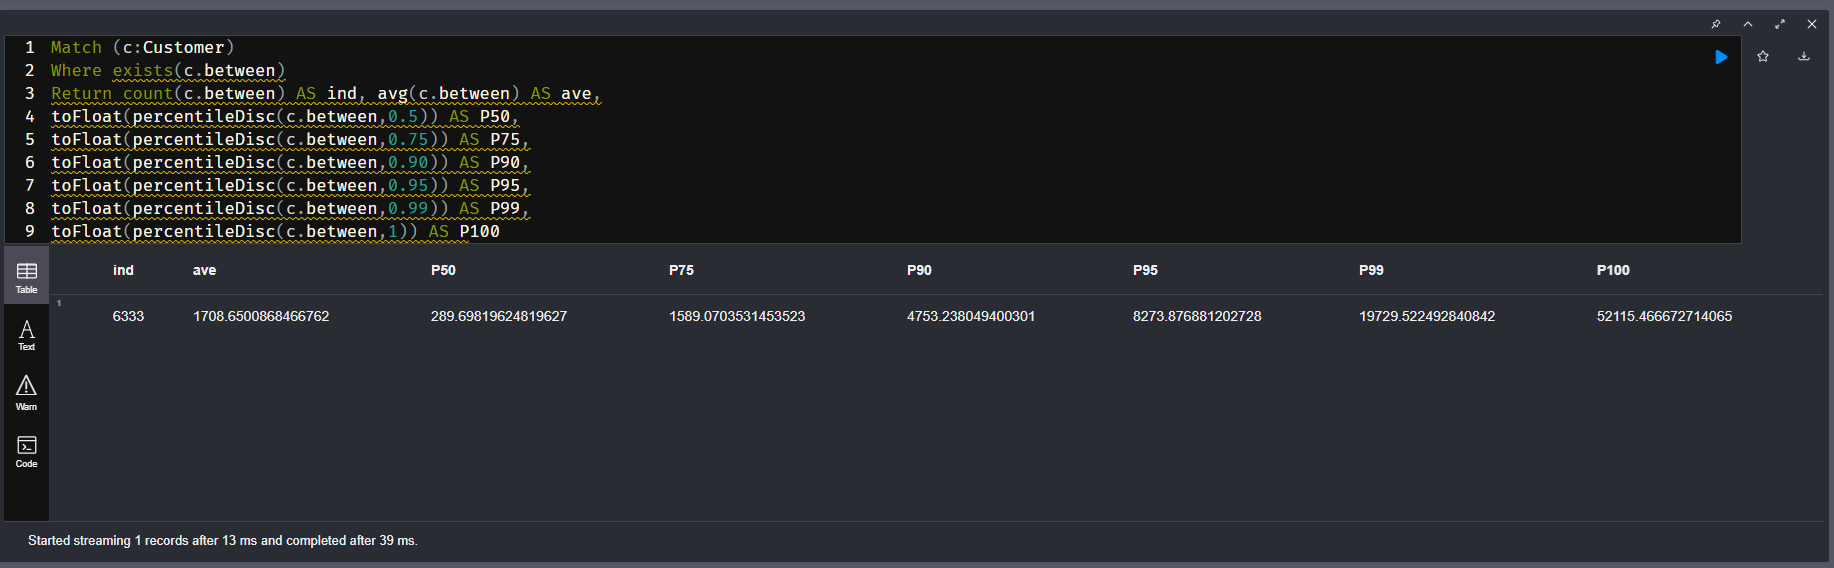

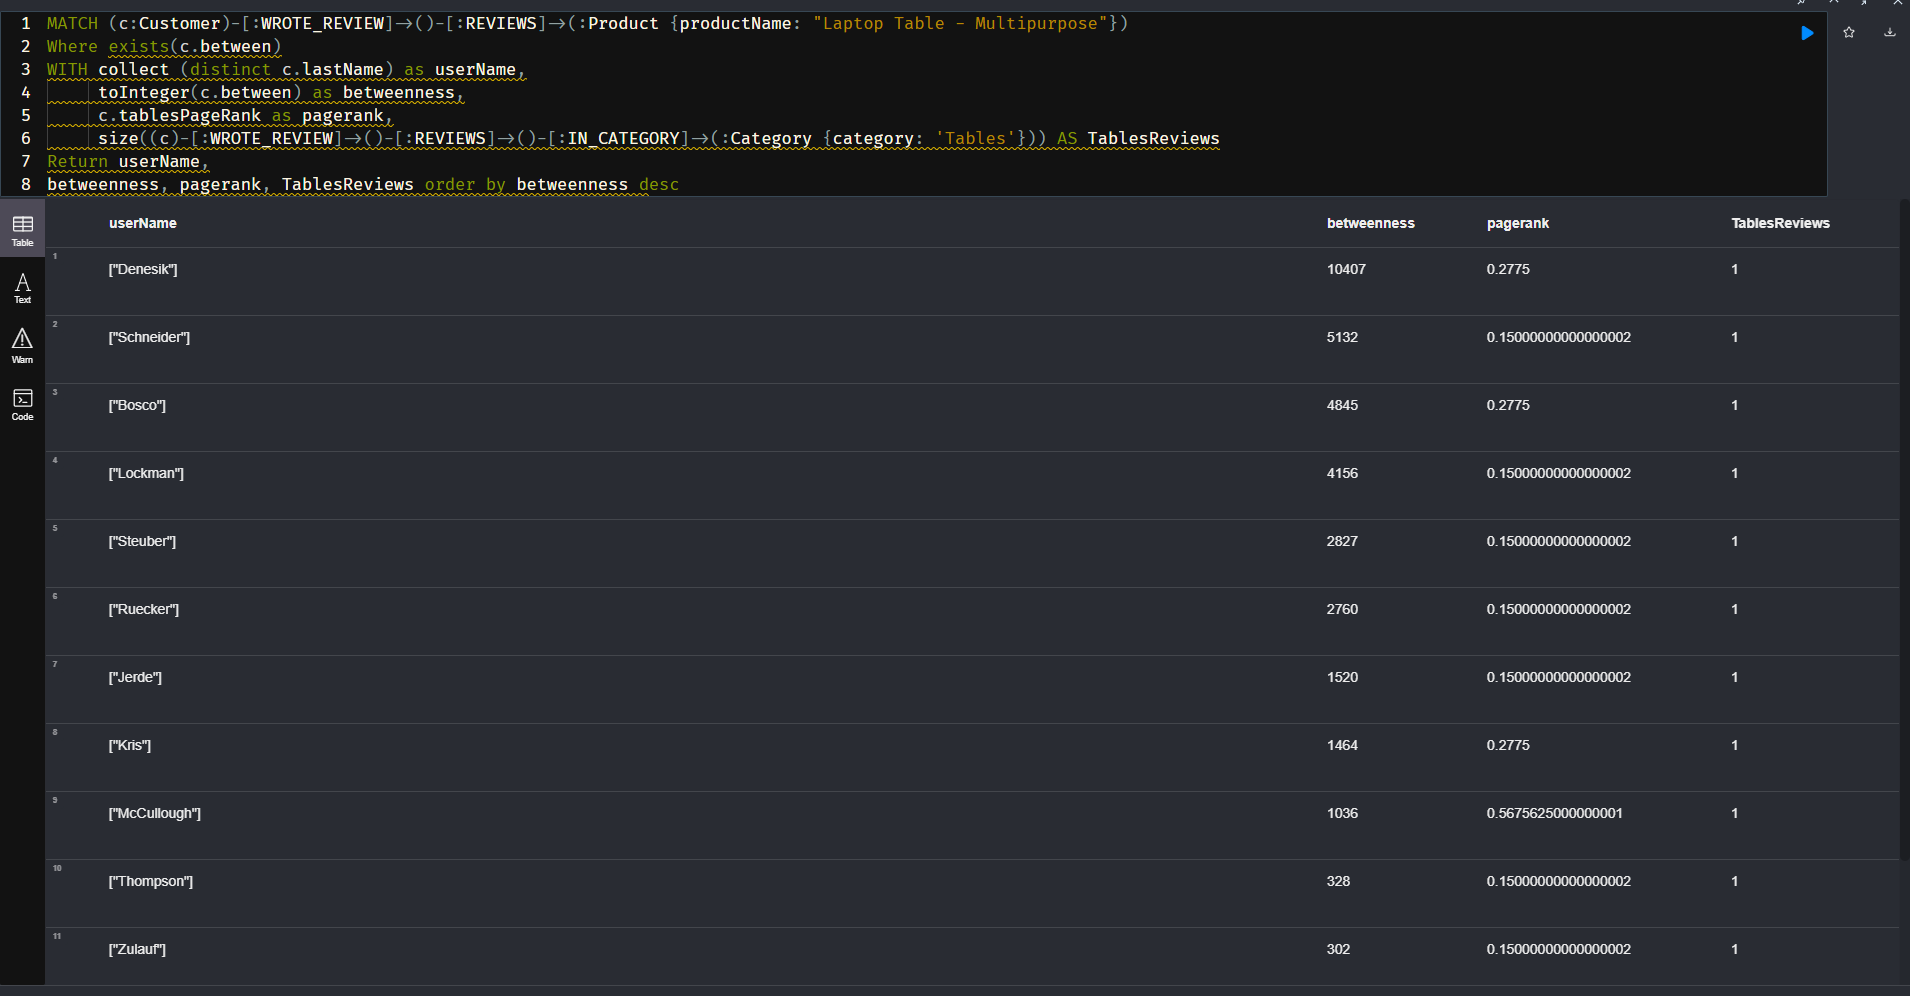

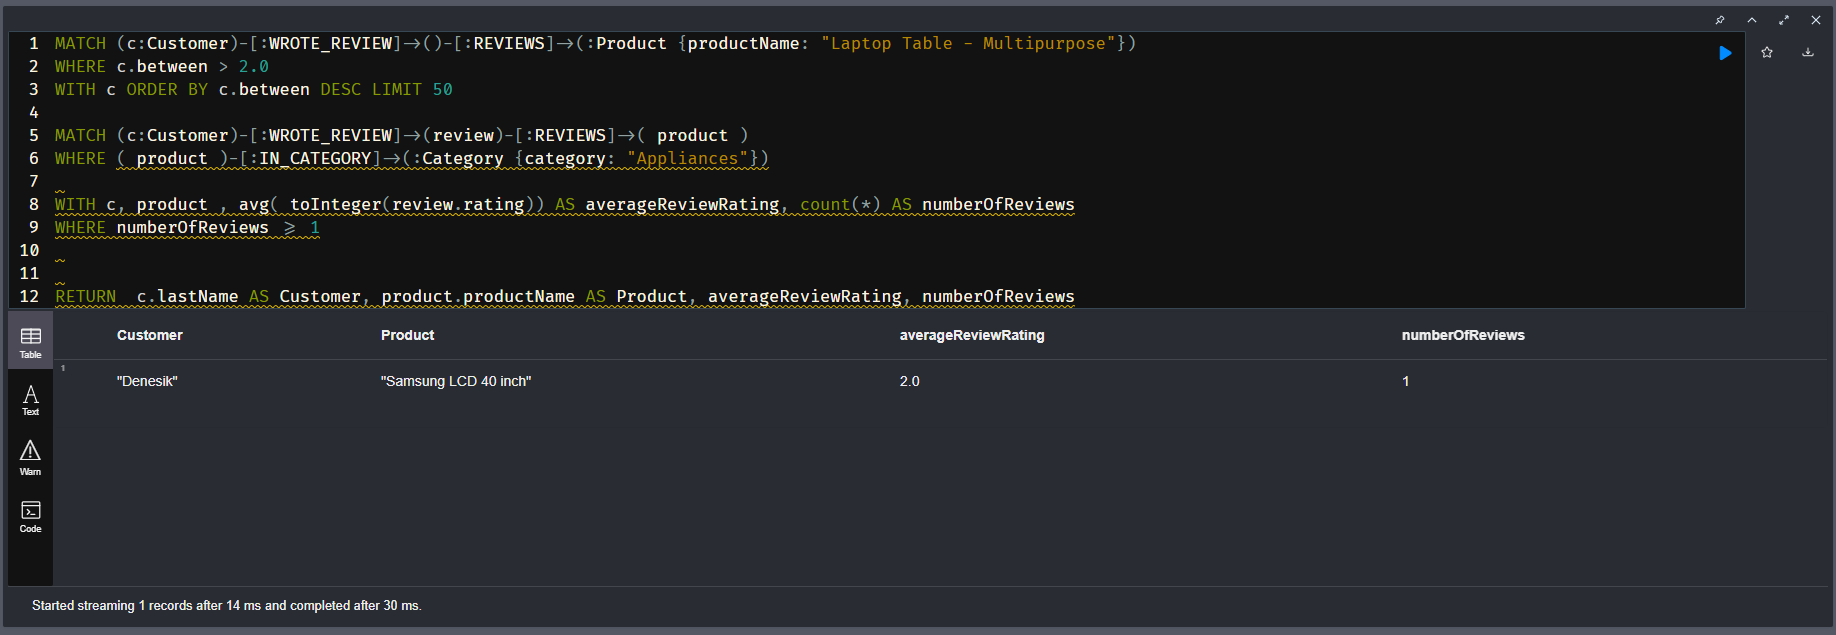

<div class="alert alert-warning">
4.	The day of the week that has the maximum number of purchases made 
</div>

In [ ]:
# use transactions.csv for requirements 4-14

In [4]:
transactions = pd.read_csv('Transactions.csv')
transactions = transactions.dropna()
transactions['Delivery_Zip_Code'] = transactions['Delivery_Zip_Code'].astype(int)
transactions.head()

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,Customer_Occupation,Credit_Card_Number,Order_ID,Order_Date,Expected_Delivery_Date,...,Product_Name,Category,Manufacturer,Review_Rating,Delivery_Tracking_ID,Delivery_Type,Delivery_Zip_Code,Transaction_Status,Order_Returned,Order_Delivered_on_Time
0,566-26-0321,Rebeka,Stokes,xxxx-xxxx-xxxx-2650,50787284-d78d-4b6a-b93f-7419b0d46590,Lawyer,12345789032,98,4/7/2020,4/11/2020,...,Fitbit small,fitness,Fitbit small,3,98,Pickup,10048,Disputed,1,1
1,274-18-0017,Rahsaan,Koch,xxxx-xxxx-xxxx-5055,f61639d7-28de-4507-a63a-71e99921d8f9,Lawyer,12345789032,131,5/10/2020,5/14/2020,...,Fitbit small,fitness,Fitbit small,3,131,Pickup,10048,Disputed,1,1
2,455-28-7950,Zion,Osinski,xxxx-xxxx-xxxx-0150,7b1caf69-bd5b-441c-9115-6fa31ba1c313,Lawyer,12345789032,318,11/13/2020,11/17/2020,...,Fitbit small,fitness,Fitbit small,3,318,Pickup,10048,Disputed,1,1
3,254-72-5938,Ward,Brekke,xxxx-xxxx-xxxx-5280,cb58e8e9-572b-4d9e-af9f-dbecf9dfd3c5,Actor,12345789032,528,2/12/2020,2/16/2020,...,Fitbit large,fitness,Fitbit large,5,528,Pickup,10048,Disputed,0,1
4,563-47-8401,Terrence,Franecki,xxxx-xxxx-xxxx-1019,a9d66460-a48f-419f-8d39-7818290a3041,Actor,12345789032,561,2/12/2020,2/16/2020,...,Fitbit large,fitness,Fitbit large,5,561,Pickup,10048,Disputed,0,1


In [5]:
transactions.dtypes

CustomerID                 object
FirstName                  object
LastName                   object
CreditCardNumber           object
OrderID                    object
Customer_Occupation        object
Credit_Card_Number          int64
Order_ID                    int64
Order_Date                 object
Expected_Delivery_Date     object
Actual_Delivery_Date       object
Product_ID                 object
Product_Name               object
Category                   object
Manufacturer               object
Review_Rating               int64
Delivery_Tracking_ID        int64
Delivery_Type              object
Delivery_Zip_Code           int64
Transaction_Status         object
Order_Returned              int64
Order_Delivered_on_Time     int64
dtype: object

In [96]:
purchases = pd.read_csv('PurchasesLog.csv')
# purchases = purchases.dropna()
# there's some garbage data in there for zipcode so if it's not a number I'm setting it to 0
purchases['DeliveryZipCode'] = purchases.DeliveryZipCode.apply(lambda x: np.where(x.isdigit(),x,'0'))
purchases['DeliveryZipCode'] = purchases['DeliveryZipCode'].astype(int)
purchases['HomeZipCode'] = purchases.HomeZipCode.apply(lambda x: np.where(x.isdigit(),x,'0'))
purchases['HomeZipCode'] = purchases['HomeZipCode'].astype(int)
purchases['ZipCodeInSupplyChainNet'] = purchases.ZipCodeInSupplyChainNet.apply(lambda x: np.where(x.isdigit(),x,'0'))
purchases['ZipCodeInSupplyChainNet'] = purchases['ZipCodeInSupplyChainNet'].astype(int)
purchases

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,PurchaseDate,DeliveryDate,ShippingClass,ProductID,Department,...,Friends,SharedWith,ZipCodeInSupplyChainNet,CityInSupplyChainNet,StateInSupplyChainNet,LatitudeInSupplyChainNet,LongitudeInSupplyChainNet,FacilityIDInSupplyChainNet,DistributionCenterIDInSupplyChainNet,WarehouseIDInSupplyChainNet
0,067-03-5110,Cary,Mosciski,xxxx-xxxx-xxxx-0112,35e3cd2f-1754-4e76-9a36-90b787a9e09c,Tue May 04 19:09:43 CDT 2021,Wed May 05 19:03:09 CDT 2021,Next Day,CLO-SH-0136-865,Clothing,...,NaN,NaN,30322,Atlanta,GA,33.793754,-84.3238,NaN,DistributionCenter_89,Warehouse_16
1,379-81-0765,Rosalee,Mayert,xxxx-xxxx-xxxx-5730,55869978-15a1-483a-bedc-58e077a9c618,Tue May 04 19:08:25 CDT 2021,Sun May 09 19:07:20 CDT 2021,Standard,ELE-PH-0848-053,Electronics,...,NaN,NaN,75353,Dallas,TX,32.767268,-96.777626,NaN,DistributionCenter_71,Warehouse_19
2,837-66-0688,Janet,Hane,xxxx-xxxx-xxxx-4536,81907ebe-fb03-477e-beff-762c744b2f9b,Tue May 04 19:00:51 CDT 2021,Sun May 09 19:11:24 CDT 2021,Standard,GRO-NU-2799-197,Grocery,...,NaN,NaN,2283,Boston,MA,42.338947,-70.919635,DistributionCenter_32,DistributionCenter_32,Warehouse_11
3,624-30-8030,Sarina,Macejkovic,xxxx-xxxx-xxxx-2356,fcdb2e71-cc75-4df6-b03b-9e4b36339fa8,Tue May 04 19:06:58 CDT 2021,Thu May 06 19:11:18 CDT 2021,Two Day,FUR-TA-9688-003,Furniture,...,NaN,NaN,11302,New York,NY,40.75945,-73.715016,NaN,DistributionCenter_20,Warehouse_7
4,893-62-1144,Shane,Daugherty,xxxx-xxxx-xxxx-2845,ccbb9640-7738-4488-b45d-776bceb01f56,Tue May 04 19:09:42 CDT 2021,Sun May 09 18:59:19 CDT 2021,Standard,SPO-AT-4470-799,Sports,...,NaN,NaN,60667,Chicago,IL,41.811929,-87.68732,NaN,DistributionCenter_1,Warehouse_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,373-28-8486,Eusebio,Raynor,xxxx-xxxx-xxxx-4991,15200b7a-8158-4800-9ae5-29ee5c157308,Tue May 04 19:10:30 CDT 2021,Thu May 06 19:11:55 CDT 2021,Two Day,OFF-AP-6460-365,Office Supplies,...,769-61-1076;881-85-0034,769-61-1076,33132,Miami,FL,25.784326,-80.18753,NaN,DistributionCenter_58,Warehouse_17
9996,614-86-2091,Myrtice,King,xxxx-xxxx-xxxx-5881,61da7732-dcf4-4d5c-bab6-129661a7f226,Tue May 04 19:07:21 CDT 2021,Wed May 05 19:22:14 CDT 2021,Next Day,SPO-GO-3297-200,Sports,...,NaN,NaN,10114,New York,NY,40.780751,-73.977182,NaN,DistributionCenter_15,Warehouse_5
9997,733-78-6363,Otha,Hettinger,xxxx-xxxx-xxxx-1430,37141b26-b25a-4818-9698-ad787f3fce4b,Tue May 04 19:15:52 CDT 2021,Sun May 09 19:08:16 CDT 2021,Standard,ELE-CO-7514-121,Electronics,...,572-82-9133,NaN,10250,New York,NY,40.709387,-74.016529,DistributionCenter_14,DistributionCenter_14,Warehouse_5
9998,303-75-9064,Shyanne,Harber,xxxx-xxxx-xxxx-6925,ebee6e9e-8c13-4c7a-9d08-d57c7a35de15,Tue May 04 19:08:04 CDT 2021,Sun May 09 19:19:44 CDT 2021,Standard,GRO-PA-0127-890,Grocery,...,809-96-0961;099-01-3334,809-96-0961;099-01-3334,30881,Atlanta,GA,33.793006,-84.504081,DistributionCenter_89,DistributionCenter_89,Warehouse_16


In [7]:
purchases.dtypes

CustomerID                               object
FirstName                                object
LastName                                 object
CreditCardNumber                         object
OrderID                                  object
PurchaseDate                             object
DeliveryDate                             object
ShippingClass                            object
ProductID                                object
Department                               object
Category                                 object
ItemPurchased                            object
Quantity                                  int64
Price                                   float64
ShippingCost                            float64
Discount                                float64
Sales                                   float64
Profit                                  float64
DistributionCenterID                     object
DeliveryZipCode                           int64
HomeZipCode                             

In [8]:
transactions['Expected_Delivery_Date'] = pd.to_datetime(transactions['Expected_Delivery_Date'])
transactions['Order_Date'] = pd.to_datetime(transactions['Order_Date'])
transactions['Actual_Delivery_Date'] = pd.to_datetime(transactions['Actual_Delivery_Date'])
# The day of the week with Monday=0, Sunday=6.
transactions['day_of_week'] = transactions['Order_Date'].dt.dayofweek
transactions.set_index('Order_Date', inplace=True)
# these are order dates instead of delivery dates this time
transactions['year'] = transactions.index.year
transactions['month'] = transactions.index.month
transactions['day'] = transactions.index.day
transactions['week_of_year'] = transactions.index.weekofyear

In [9]:
transactions.dtypes

CustomerID                         object
FirstName                          object
LastName                           object
CreditCardNumber                   object
OrderID                            object
Customer_Occupation                object
Credit_Card_Number                  int64
Order_ID                            int64
Expected_Delivery_Date     datetime64[ns]
Actual_Delivery_Date       datetime64[ns]
Product_ID                         object
Product_Name                       object
Category                           object
Manufacturer                       object
Review_Rating                       int64
Delivery_Tracking_ID                int64
Delivery_Type                      object
Delivery_Zip_Code                   int64
Transaction_Status                 object
Order_Returned                      int64
Order_Delivered_on_Time             int64
day_of_week                         int64
year                                int64
month                             

In [10]:
transactions.head()

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,Customer_Occupation,Credit_Card_Number,Order_ID,Expected_Delivery_Date,Actual_Delivery_Date,...,Delivery_Type,Delivery_Zip_Code,Transaction_Status,Order_Returned,Order_Delivered_on_Time,day_of_week,year,month,day,week_of_year
Order_Date,,,,,,,,,,,,,,,,,,,,,
2020-04-07,566-26-0321,Rebeka,Stokes,xxxx-xxxx-xxxx-2650,50787284-d78d-4b6a-b93f-7419b0d46590,Lawyer,12345789032,98,2020-04-11,2020-04-15,...,Pickup,10048,Disputed,1,1,1,2020,4,7,15
2020-05-10,274-18-0017,Rahsaan,Koch,xxxx-xxxx-xxxx-5055,f61639d7-28de-4507-a63a-71e99921d8f9,Lawyer,12345789032,131,2020-05-14,2020-05-18,...,Pickup,10048,Disputed,1,1,6,2020,5,10,19
2020-11-13,455-28-7950,Zion,Osinski,xxxx-xxxx-xxxx-0150,7b1caf69-bd5b-441c-9115-6fa31ba1c313,Lawyer,12345789032,318,2020-11-17,2020-11-21,...,Pickup,10048,Disputed,1,1,4,2020,11,13,46
2020-02-12,254-72-5938,Ward,Brekke,xxxx-xxxx-xxxx-5280,cb58e8e9-572b-4d9e-af9f-dbecf9dfd3c5,Actor,12345789032,528,2020-02-16,2020-02-20,...,Pickup,10048,Disputed,0,1,2,2020,2,12,7
2020-02-12,563-47-8401,Terrence,Franecki,xxxx-xxxx-xxxx-1019,a9d66460-a48f-419f-8d39-7818290a3041,Actor,12345789032,561,2020-02-16,2020-02-20,...,Pickup,10048,Disputed,0,1,2,2020,2,12,7


In [11]:
df_transactions_count = transactions.groupby(['day_of_week'])['Order_ID'].count() \
                        .reset_index(name ='total_number_of_transactions')

df_transactions_count.sort_values('total_number_of_transactions', ascending=False)

,day_of_week,total_number_of_transactions
3,3,2584
2,2,2493
4,4,2484
1,1,2289
5,5,2251
0,0,2222
6,6,2049


The purchases data is all from a single day of the year and therefore all on a Tuesday

<div class="alert alert-warning">
5.	The month of the year that has the highest sales revenue
</div>

In [12]:
df_merged = transactions.merge(purchases, left_on='OrderID', right_on='OrderID')
print(df_merged.columns)
df_merged

Index(['CustomerID_x', 'FirstName_x', 'LastName_x', 'CreditCardNumber_x',
       'OrderID', 'Customer_Occupation', 'Credit_Card_Number', 'Order_ID',
       'Expected_Delivery_Date', 'Actual_Delivery_Date', 'Product_ID',
       'Product_Name', 'Category_x', 'Manufacturer', 'Review_Rating',
       'Delivery_Tracking_ID', 'Delivery_Type', 'Delivery_Zip_Code',
       'Transaction_Status', 'Order_Returned', 'Order_Delivered_on_Time',
       'day_of_week', 'year', 'month', 'day', 'week_of_year', 'CustomerID_y',
       'FirstName_y', 'LastName_y', 'CreditCardNumber_y', 'PurchaseDate',
       'DeliveryDate', 'ShippingClass', 'ProductID', 'Department',
       'Category_y', 'ItemPurchased', 'Quantity', 'Price', 'ShippingCost',
       'Discount', 'Sales', 'Profit', 'DistributionCenterID',
       'DeliveryZipCode', 'HomeZipCode', 'TransactionStatus', 'City', 'Region',
       'State', 'Country', 'Segment', 'OrderPriority', 'OrderReturned',
       'OrderDeliveryDelayed', 'Rating', 'ReviewID', 'Frien

,CustomerID_x,FirstName_x,LastName_x,CreditCardNumber_x,OrderID,Customer_Occupation,Credit_Card_Number,Order_ID,Expected_Delivery_Date,Actual_Delivery_Date,...,Friends,SharedWith,ZipCodeInSupplyChainNet,CityInSupplyChainNet,StateInSupplyChainNet,LatitudeInSupplyChainNet,LongitudeInSupplyChainNet,FacilityIDInSupplyChainNet,DistributionCenterIDInSupplyChainNet,WarehouseIDInSupplyChainNet


Apparently there is no crossover between the purchases and transactions csvs...

*** At this point in the data I began looking at the questions that I needed to answer and determined it would be impossible to answer them with the transactions.csv file as instructed. I was able to get the day of the week, but it would be impossible to meet requirement 5 with transactions.csv because no dollar amounts are included and the two data files do not join. The sync session must have misspoken. ***
<br>
<br>
*** It would also be impossible to answer this question with purchases.csv because that log is all from a single day, so while it has the dollar amounts it will not show varying months...I'm going to get creative in order to move forward***

In [13]:
purchases.dtypes

CustomerID                               object
FirstName                                object
LastName                                 object
CreditCardNumber                         object
OrderID                                  object
PurchaseDate                             object
DeliveryDate                             object
ShippingClass                            object
ProductID                                object
Department                               object
Category                                 object
ItemPurchased                            object
Quantity                                  int64
Price                                   float64
ShippingCost                            float64
Discount                                float64
Sales                                   float64
Profit                                  float64
DistributionCenterID                     object
DeliveryZipCode                           int64
HomeZipCode                             

In [14]:
# simulate seasonality
# using purchases.csv because of the dollar values included
def random_dates(start, end, n=10):
    if not isinstance(start, datetime):
        start = pd.to_datetime(start)
    if not isinstance(end, datetime):
        end = pd.to_datetime(end)
    
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

In [97]:
purchases['PurchaseDate'] = pd.to_datetime(purchases['PurchaseDate'])
purchases['DeliveryDate'] = pd.to_datetime(purchases['DeliveryDate'])

purchases.PurchaseDate = random_dates('2019-01-01', '2022-01-01', len(purchases.PurchaseDate))
purchases

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,PurchaseDate,DeliveryDate,ShippingClass,ProductID,Department,...,Friends,SharedWith,ZipCodeInSupplyChainNet,CityInSupplyChainNet,StateInSupplyChainNet,LatitudeInSupplyChainNet,LongitudeInSupplyChainNet,FacilityIDInSupplyChainNet,DistributionCenterIDInSupplyChainNet,WarehouseIDInSupplyChainNet
0,067-03-5110,Cary,Mosciski,xxxx-xxxx-xxxx-0112,35e3cd2f-1754-4e76-9a36-90b787a9e09c,2021-11-12 10:12:46,2021-05-05 19:03:09,Next Day,CLO-SH-0136-865,Clothing,...,NaN,NaN,30322,Atlanta,GA,33.793754,-84.3238,NaN,DistributionCenter_89,Warehouse_16
1,379-81-0765,Rosalee,Mayert,xxxx-xxxx-xxxx-5730,55869978-15a1-483a-bedc-58e077a9c618,2019-01-25 16:35:38,2021-05-09 19:07:20,Standard,ELE-PH-0848-053,Electronics,...,NaN,NaN,75353,Dallas,TX,32.767268,-96.777626,NaN,DistributionCenter_71,Warehouse_19
2,837-66-0688,Janet,Hane,xxxx-xxxx-xxxx-4536,81907ebe-fb03-477e-beff-762c744b2f9b,2021-11-07 12:08:24,2021-05-09 19:11:24,Standard,GRO-NU-2799-197,Grocery,...,NaN,NaN,2283,Boston,MA,42.338947,-70.919635,DistributionCenter_32,DistributionCenter_32,Warehouse_11
3,624-30-8030,Sarina,Macejkovic,xxxx-xxxx-xxxx-2356,fcdb2e71-cc75-4df6-b03b-9e4b36339fa8,2019-12-16 12:51:57,2021-05-06 19:11:18,Two Day,FUR-TA-9688-003,Furniture,...,NaN,NaN,11302,New York,NY,40.75945,-73.715016,NaN,DistributionCenter_20,Warehouse_7
4,893-62-1144,Shane,Daugherty,xxxx-xxxx-xxxx-2845,ccbb9640-7738-4488-b45d-776bceb01f56,2021-08-07 22:00:55,2021-05-09 18:59:19,Standard,SPO-AT-4470-799,Sports,...,NaN,NaN,60667,Chicago,IL,41.811929,-87.68732,NaN,DistributionCenter_1,Warehouse_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,373-28-8486,Eusebio,Raynor,xxxx-xxxx-xxxx-4991,15200b7a-8158-4800-9ae5-29ee5c157308,2021-12-21 16:10:03,2021-05-06 19:11:55,Two Day,OFF-AP-6460-365,Office Supplies,...,769-61-1076;881-85-0034,769-61-1076,33132,Miami,FL,25.784326,-80.18753,NaN,DistributionCenter_58,Warehouse_17
9996,614-86-2091,Myrtice,King,xxxx-xxxx-xxxx-5881,61da7732-dcf4-4d5c-bab6-129661a7f226,2020-03-13 02:35:15,2021-05-05 19:22:14,Next Day,SPO-GO-3297-200,Sports,...,NaN,NaN,10114,New York,NY,40.780751,-73.977182,NaN,DistributionCenter_15,Warehouse_5
9997,733-78-6363,Otha,Hettinger,xxxx-xxxx-xxxx-1430,37141b26-b25a-4818-9698-ad787f3fce4b,2019-10-09 00:36:59,2021-05-09 19:08:16,Standard,ELE-CO-7514-121,Electronics,...,572-82-9133,NaN,10250,New York,NY,40.709387,-74.016529,DistributionCenter_14,DistributionCenter_14,Warehouse_5
9998,303-75-9064,Shyanne,Harber,xxxx-xxxx-xxxx-6925,ebee6e9e-8c13-4c7a-9d08-d57c7a35de15,2019-11-14 01:42:34,2021-05-09 19:19:44,Standard,GRO-PA-0127-890,Grocery,...,809-96-0961;099-01-3334,809-96-0961;099-01-3334,30881,Atlanta,GA,33.793006,-84.504081,DistributionCenter_89,DistributionCenter_89,Warehouse_16


In [128]:
# day of the week that has the maximum purchases made
df_purchases_count = purchases[['PurchaseDate', 'OrderID']]
df_purchases_count['day_of_week'] = purchases.PurchaseDate.dt.weekday
df_purchases_count = df_purchases_count.groupby(['day_of_week'])['OrderID'].count() \
                        .reset_index(name ='total_number_of_purchases')

df_purchases_count.sort_values('total_number_of_purchases', ascending=False)

,day_of_week,total_number_of_purchases
6,6,1464
2,2,1462
1,1,1461
3,3,1449
5,5,1406
4,4,1387
0,0,1371


Highest sales day of the week for this data is Sunday

In [129]:
df_montly_rev = purchases[['PurchaseDate', 'Sales']]
df_montly_rev['month'] = df_montly_rev.PurchaseDate.dt.month
df_montly_rev = df_montly_rev.groupby(['month'])['Sales'].sum() \
                        .reset_index(name ='total_sales_revenue')
df_montly_rev.sort_values('total_sales_revenue', ascending=False)



,month,total_sales_revenue
0,1,871827.49
11,12,870865.31
4,5,837258.70
2,3,804656.00
8,9,802721.77
9,10,785793.89
5,6,775069.42
7,8,773836.89
6,7,752542.50
1,2,741309.54


January had the most sales.

<div class="alert alert-warning">
6.	The weekly sales revenue forecast per zip-code
</div>

In [131]:
df_weekly_rev = purchases[['DeliveryZipCode','PurchaseDate', 'Sales']]
df_weekly_rev['week'] = df_weekly_rev.PurchaseDate.dt.week
df_weekly_rev = df_weekly_rev.groupby(['DeliveryZipCode','week'])['Sales'].sum() \
                        .reset_index(name ='WeeklySales')
df_weekly_rev

,DeliveryZipCode,week,WeeklySales
0,0,25,20.65
1,0,27,23.81
2,0,44,432.56
3,0,45,3017.61
4,0,50,8813.33
...,...,...,...
8932,91671,39,40.86
8933,91671,40,26.40
8934,91671,46,286.34
8935,91671,47,3163.06


In [132]:
print('\nAverage weekly sales (forecast):')
print(pd.DataFrame(
        df_weekly_rev.groupby(['DeliveryZipCode'])['WeeklySales'].mean()
        ).sort_values('WeeklySales', ascending=False))


Average weekly sales (forecast):
                 WeeklySales
DeliveryZipCode             
2201             3505.790000
90079            3440.435714
33125            3173.757778
90041            3158.600000
90044            3059.816667
...                      ...
60660             155.056364
60609             150.157143
10169             143.872857
30313             107.217778
33199              87.418000

[786 rows x 1 columns]


In [133]:
df_rev_allzip_weekly = df_weekly_rev.rename(columns = {'DeliveryZipCode': 'ds',
                                'WeeklySales': 'y'})

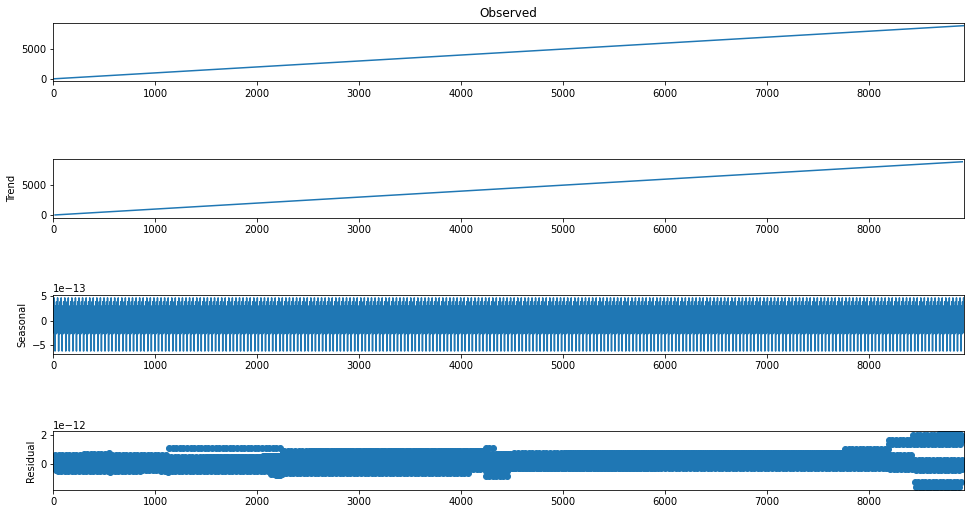

In [134]:
df_rev_allzip_weekly.set_index('ds')
predict = sm.tsa.seasonal_decompose(df_rev_allzip_weekly.index, period=35)
figure = predict.plot()
figure.set_size_inches(15, 8)

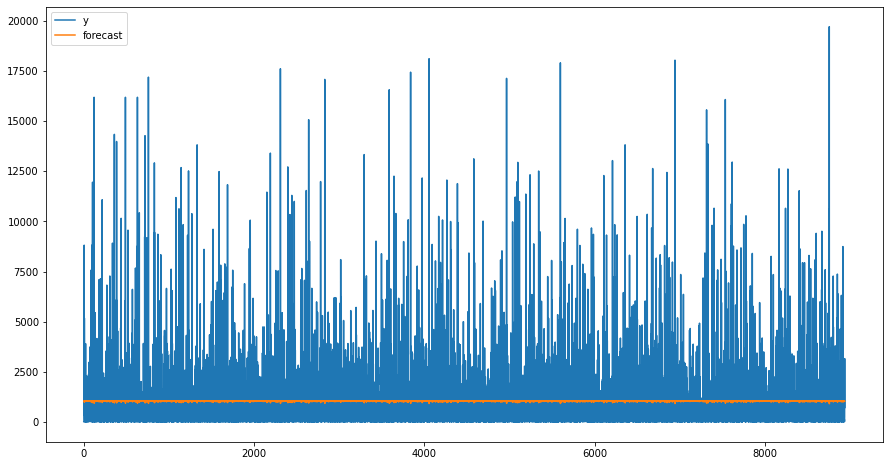

In [135]:
df_stats_model = df_rev_allzip_weekly
model = sm.tsa.ARIMA(df_stats_model['y'].iloc[1:], order = (1,0,0))
results = model.fit()
df_stats_model['forecast'] = results.fittedvalues
df_stats_model[['y', 'forecast']].plot(figsize=(15,8))

<div class="alert alert-warning">
7.	The daily number of purchases forecast per distribution center

</div>

In [136]:
df_daily_rev = purchases[['DistributionCenterID','PurchaseDate', 'Sales']]
df_daily_rev['day'] = df_daily_rev.PurchaseDate.dt.day
df_daily_rev = df_daily_rev.groupby(['DistributionCenterID','day'])['Sales'].sum() \
                        .reset_index(name ='DailySales')
df_daily_rev

,DistributionCenterID,day,DailySales
0,Distribution Center ID Serving this Zip Code,2,23.81
1,Distribution Center ID Serving this Zip Code,3,3017.61
2,Distribution Center ID Serving this Zip Code,5,432.56
3,Distribution Center ID Serving this Zip Code,10,8813.33
4,Distribution Center ID Serving this Zip Code,27,20.65
...,...,...,...
2792,DistributionCenter_97,26,15841.64
2793,DistributionCenter_97,28,6359.17
2794,DistributionCenter_97,29,98.08
2795,DistributionCenter_97,30,6020.95


In [137]:
print('Average daily sales (forecast):')
print(pd.DataFrame(
        df_daily_rev.groupby(['DistributionCenterID'])['DailySales'].mean().astype('int')
        ).sort_values('DailySales', ascending=False))

Average daily sales (forecast):
                       DailySales
DistributionCenterID             
DistributionCenter_89        8502
DistributionCenter_19        8169
DistributionCenter_95        7356
DistributionCenter_14        6432
DistributionCenter_21        5749
...                           ...
DistributionCenter_36        1519
DistributionCenter_64        1498
DistributionCenter_26        1426
DistributionCenter_58        1319
DistributionCenter_49         834

[98 rows x 1 columns]


<div class="alert alert-warning">
8.	The weekly number of product returns forecast per warehouse
    
</div>

In [138]:
purchases.OrderReturned = purchases.OrderReturned.replace({'Yes':1,'No':0})
df_week_returns = purchases[['WarehouseIDInSupplyChainNet','PurchaseDate', 'OrderReturned']]
df_week_returns['week'] = df_week_returns.PurchaseDate.dt.week
df_week_returns = df_week_returns.groupby(['WarehouseIDInSupplyChainNet','week'])['OrderReturned'].sum() \
                        .reset_index(name ='WeeklyReturns')
df_week_returns

,WarehouseIDInSupplyChainNet,week,WeeklyReturns
0,Warehouse ID supplying this Distribution Center,25,0
1,Warehouse ID supplying this Distribution Center,27,0
2,Warehouse ID supplying this Distribution Center,44,0
3,Warehouse ID supplying this Distribution Center,45,1
4,Warehouse ID supplying this Distribution Center,50,0
...,...,...,...
1155,Warehouse_9,49,0
1156,Warehouse_9,50,1
1157,Warehouse_9,51,1
1158,Warehouse_9,52,1


In [139]:
print('forecast based on average weekly sales:')
print(pd.DataFrame(
        df_week_returns.groupby(['WarehouseIDInSupplyChainNet'])['WeeklyReturns'].mean()
        ).sort_values('WeeklyReturns', ascending=False))

forecast based on average weekly sales:
                                                 WeeklyReturns
WarehouseIDInSupplyChainNet                                   
Warehouse_17                                          5.905660
Warehouse_2                                           3.641509
Warehouse_16                                          3.433962
Warehouse_19                                          1.924528
Warehouse_3                                           1.905660
Warehouse_13                                          1.830189
Warehouse_5                                           1.830189
Warehouse_14                                          1.773585
Warehouse_20                                          1.622642
Warehouse_11                                          1.566038
Warehouse_6                                           1.566038
Warehouse_7                                           1.509434
Warehouse_9                                           1.056604
Warehouse_12   

<div class="alert alert-warning">
9.	Whether the number of delayed deliveries per zip-code positively correlated to the number of returned purchases/products.    
</div>

In [140]:
df_corr = purchases[['DeliveryZipCode','OrderReturned', 'OrderDeliveryDelayed']]
df_corr

,DeliveryZipCode,OrderReturned,OrderDeliveryDelayed
0,30322,1,1
1,75353,1,0
2,2283,0,0
3,11302,1,1
4,60667,0,1
...,...,...,...
9995,33132,0,0
9996,10114,0,1
9997,10250,0,1
9998,30881,1,1


In [141]:
purchases.OrderDeliveryDelayed = purchases.OrderDeliveryDelayed.replace({'Yes':1,'No':0})
df_corr = purchases[['DeliveryZipCode','OrderReturned', 'OrderDeliveryDelayed']]
df_corr

,DeliveryZipCode,OrderReturned,OrderDeliveryDelayed
0,30322,1,1
1,75353,1,0
2,2283,0,0
3,11302,1,1
4,60667,0,1
...,...,...,...
9995,33132,0,0
9996,10114,0,1
9997,10250,0,1
9998,30881,1,1


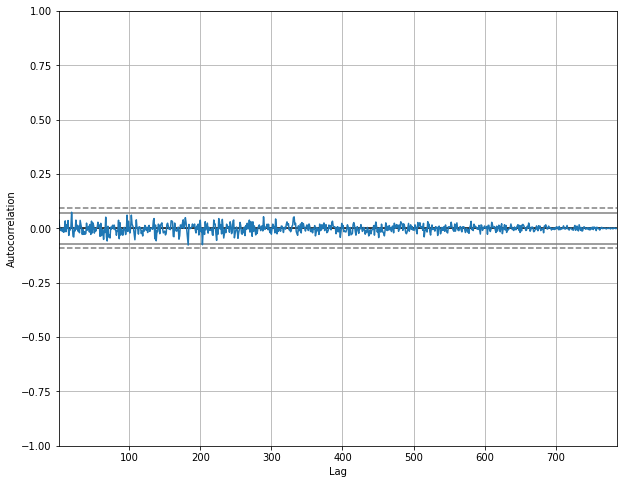

In [142]:
df_deliveries_count = df_corr
df_deliveries_count = df_deliveries_count.groupby(['DeliveryZipCode'])['OrderReturned', 'OrderDeliveryDelayed'].sum()
plt.figure(figsize=(10,8))
pd.plotting.autocorrelation_plot(df_deliveries_count)
plt.show()

Looks like there are 2 or 3 significant values here

<div class="alert alert-warning">
10.	The busiest zip code (counting both deliveries and purchase returns)
</div>

In [143]:
df_deliveries_returns_count = purchases[['DeliveryZipCode','OrderReturned', 'OrderID']]
df_deliveries_returns_count = df_deliveries_returns_count.groupby(['DeliveryZipCode']) \
                        .agg({
                            'OrderReturned':'sum',
                            'OrderID':'count'
                            })
df_deliveries_returns_count['busy'] = df_deliveries_returns_count['OrderReturned'] + df_deliveries_returns_count['OrderID']
print('the busiest zip code was {} and it had {} total orders + returns'.format(
      df_deliveries_returns_count.sort_values('busy', ascending=False).index[0],
      df_deliveries_returns_count.sort_values('busy', ascending=False).iloc[0]['busy'])
     )

the busiest zip code was 10281 and it had 36 total orders + returns


<div class="alert alert-warning">
11.	The most selling product in every zip-code
</div>

In [144]:
df_pop_prod = pd.DataFrame(purchases.groupby(['DeliveryZipCode', 'ItemPurchased'])['OrderID'].agg(['count']))
df_pop_prod = df_pop_prod.reset_index()
df_pop_prod.sort_values('count', ascending=False).drop_duplicates(['DeliveryZipCode'])

,DeliveryZipCode,ItemPurchased,count
2569,11302,AMS Bowfishing Crossbow Carp Kit - Right Hand,4
1939,10162,Doritos Flavored Tortilla Chips Variety Pack,3
2439,10278,Epsilon Card Laser Printer - Red,3
8412,90010,Under Armour Men's HeatGear,3
5182,37206,Cisco Router - Ethernet,3
...,...,...,...
3292,30357,PVC Carpeting,1
3349,30362,Rotini Multigrain Pasta,1
3236,30353,Muzzy LV-X Bowfishing Lever Bow and Kit Powere...,1
3228,30351,Wonderful Pistachios Roasted,1


<div class="alert alert-warning">
12.	Analyze whether the sales of the Electronics department  and  the Clothing department have similar seasonal patterns
</div>

Electronics

In [99]:
df_electronics = purchases[purchases.Department=='Electronics']
df_electronics = df_electronics.groupby(['DeliveryDate'])['OrderID'].count().reset_index(name ='total_number_of_orders')
df_electronics = df_electronics.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'total_number_of_orders': 'y'})

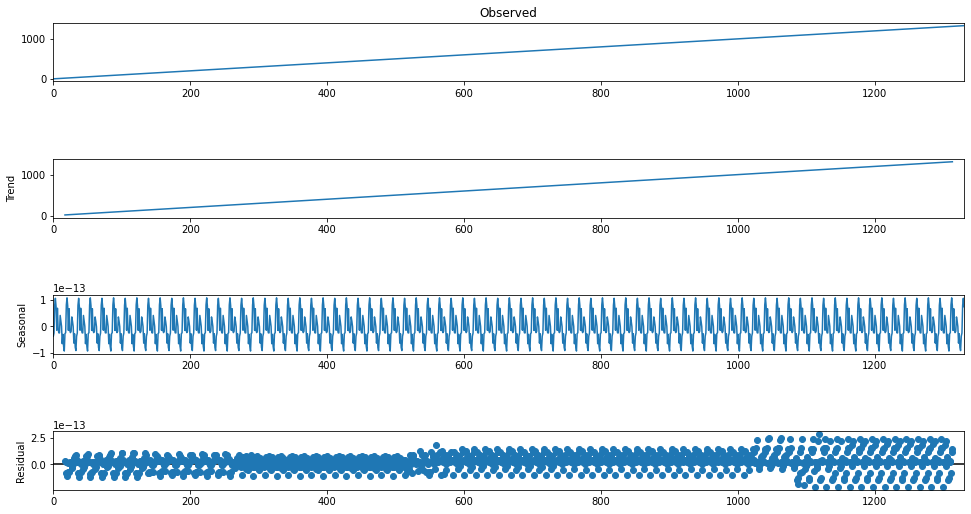

In [100]:
predict = sm.tsa.seasonal_decompose(df_electronics.index, period=34)
figure = predict.plot()
figure.set_size_inches(15, 8)

Clothing

In [101]:
df_clothing = purchases[purchases.Department=='Clothing']
df_clothing = df_clothing.groupby(['DeliveryDate'])['OrderID'].count().reset_index(name ='total_number_of_orders')
df_clothing = df_clothing.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'total_number_of_orders': 'y'})

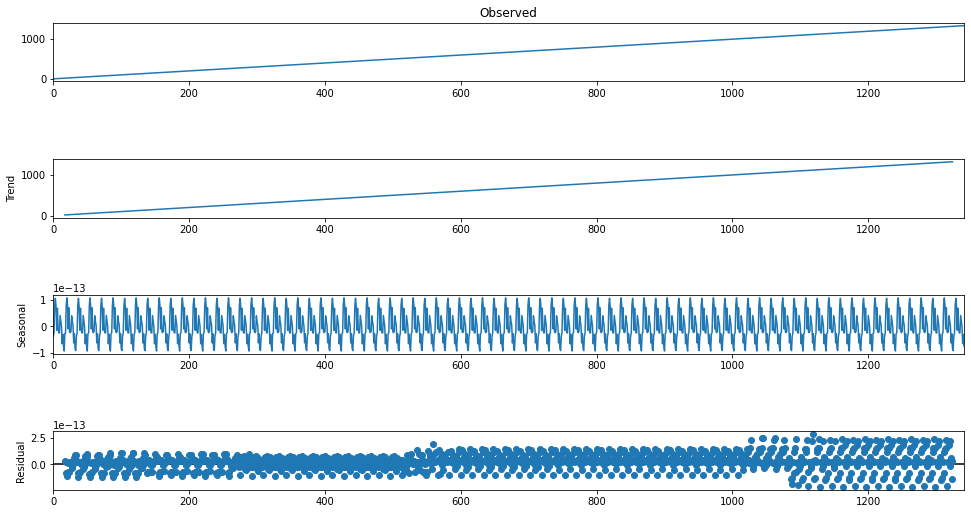

In [102]:
predict = sm.tsa.seasonal_decompose(df_clothing.index, period=34)
figure = predict.plot()
figure.set_size_inches(15, 8)

Clothing and Electronics do seem to have very similar seasonal patterns.

<div class="alert alert-warning">
13.	Product purchases seasonality through the year; for example, Back-to-School, Christmas, Superbowl, Weather, etc.
</div>

In [103]:
purchases.Category.unique()

array(['Shorts', 'Phones', 'Nuts', 'Tables', 'Athletic Clothing',
       'Appliances', 'Pasta', 'Hunting & Fishing', 'TShirt',
       'Accessories', 'Fitness', 'Machines', 'Copiers', 'Art',
       'Furnishings', 'Snaks', 'Bookcases', 'Binders', 'Beans', 'Chairs',
       'Golf'], dtype=object)

In [108]:
art = purchases[purchases.Category=='Art']
art = art.groupby(['DeliveryDate'])['OrderID'].count().reset_index(name ='total_number_of_orders')
art = art.rename(columns = {'DeliveryDate': 'ds',
                                'total_number_of_orders': 'y'})
 
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(art) 
future_dates1 = model.make_future_dataframe(periods = 50, freq='W')
forecast1 = model.predict(future_dates1)

plot_plotly(model, forecast1)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


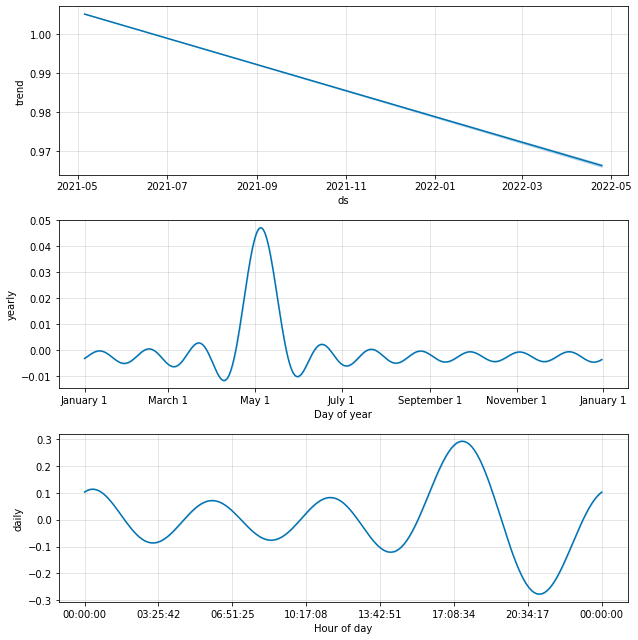

In [109]:
model.plot_components(forecast1);

In [110]:
# this could be snacks or snakes - I enjoy the ambiguity
snaks = purchases[purchases.Category=='Snaks']
snaks = snaks.groupby(['DeliveryDate'])['OrderID'].count().reset_index(name ='total_number_of_orders')
snaks = snaks.rename(columns = {'DeliveryDate': 'ds',
                                'total_number_of_orders': 'y'})
 
model2 = Prophet(yearly_seasonality=True, daily_seasonality=True)
model2.fit(snaks) 
future_dates2 = model2.make_future_dataframe(periods = 50, freq='W')
forecast2 = model2.predict(future_dates2)

plot_plotly(model2, forecast2)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


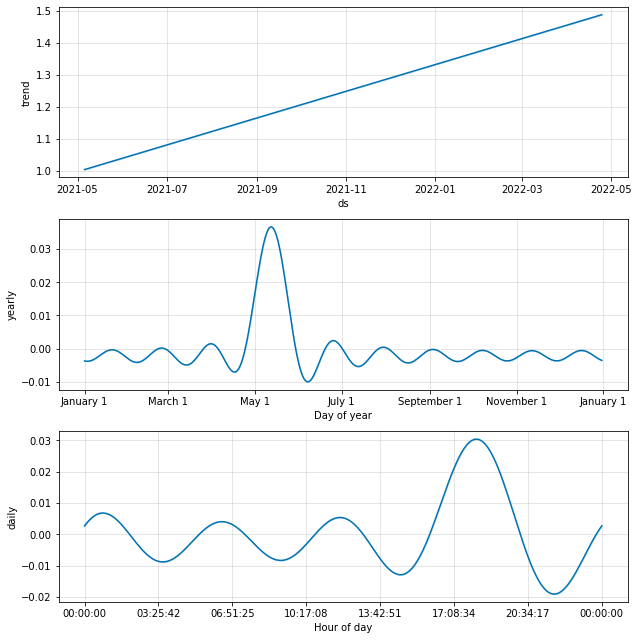

In [111]:
model2.plot_components(forecast2);

It appears that May-June is a popular time to purchase art as well as snaks

<div class="alert alert-warning">
14.	Build time series analysis model for product X (specify product)  in zip-code Y (specify zip code) to forecast daily sales revenue
</div>

In [112]:
purchases.ItemPurchased.unique()

array(["Champion Men's Sportswear Shorts", 'Motorola Smart Phone',
       'Planters Deluxe Lightly Salted Whole Cashews',
       'Computer Table - Bottom Storage', "Under Armour Men's HeatGear",
       'Wonderful Pistachios Roasted', 'Samsung LCD 40 inch',
       'Spaghetti Wheat Pasta', 'Allen Solly White Shorts',
       'AMS Bowfishing Crossbow Carp Kit - Right Hand',
       "LP Men's Formal TShirt", 'Logitech 10 GB Pen Drive',
       'Lively Conference Table - Assembled', 'Casuals Pocket T-Shirt',
       'Sunny Magnetic Rowing Machine - SF-RW5801',
       'Samsung Inkjet - Red', 'Nokia Smart Phone',
       'Canon High-Speed Scanner', 'Lumber Crayons',
       'Granite Flooring Mat',
       'Doritos Flavored Tortilla Chips Variety Pack', 'Spiral Egg Pasta',
       'Breville Refrigerator - Red', 'Jockey Black Shorts',
       'Dania Classic Bookcase - Metal', 'Onida LED 32 inch',
       'Jockey Navy Blue T-Shirt', 'Heavy Duty Binders',
       'Sharp Fax Machine - Digital', 'Athlon Optic

In [113]:
# we do not have enough transactions of any product to do this calculation
# so we will simulate the transactions by changing the item purchased to be a single item
# to be delivered to a single zip code

ts_analysis_df = purchases[['PurchaseDate', 'DeliveryZipCode', 'OrderID', 'ItemPurchased']]
ts_analysis_df.ItemPurchased = "Cisco Router - Ethernet"
ts_analysis_df.DeliveryZipCode = 60535
ts_analysis_df

,PurchaseDate,DeliveryZipCode,OrderID,ItemPurchased
0,2021-11-12 10:12:46,60535,35e3cd2f-1754-4e76-9a36-90b787a9e09c,Cisco Router - Ethernet
1,2019-01-25 16:35:38,60535,55869978-15a1-483a-bedc-58e077a9c618,Cisco Router - Ethernet
2,2021-11-07 12:08:24,60535,81907ebe-fb03-477e-beff-762c744b2f9b,Cisco Router - Ethernet
3,2019-12-16 12:51:57,60535,fcdb2e71-cc75-4df6-b03b-9e4b36339fa8,Cisco Router - Ethernet
4,2021-08-07 22:00:55,60535,ccbb9640-7738-4488-b45d-776bceb01f56,Cisco Router - Ethernet
...,...,...,...,...
9995,2021-12-21 16:10:03,60535,15200b7a-8158-4800-9ae5-29ee5c157308,Cisco Router - Ethernet
9996,2020-03-13 02:35:15,60535,61da7732-dcf4-4d5c-bab6-129661a7f226,Cisco Router - Ethernet
9997,2019-10-09 00:36:59,60535,37141b26-b25a-4818-9698-ad787f3fce4b,Cisco Router - Ethernet
9998,2019-11-14 01:42:34,60535,ebee6e9e-8c13-4c7a-9d08-d57c7a35de15,Cisco Router - Ethernet


In [117]:
# there isn't enough variation to show anything of substance over time so
# simulate 100 days with an increased number of orders
import random

for i in range(100):
    row_choice_rand = random.randint(0, len(ts_analysis_df))
    # random number of times to replicate the row
    x_rand = random.randint(0, 50)
    ts_analysis_df = ts_analysis_df.append([ts_analysis_df.iloc[row_choice_rand]]*x_rand,ignore_index=True)
    
ts_analysis_df

,PurchaseDate,DeliveryZipCode,OrderID,ItemPurchased
0,2021-11-12 10:12:46,60535,35e3cd2f-1754-4e76-9a36-90b787a9e09c,Cisco Router - Ethernet
1,2019-01-25 16:35:38,60535,55869978-15a1-483a-bedc-58e077a9c618,Cisco Router - Ethernet
2,2021-11-07 12:08:24,60535,81907ebe-fb03-477e-beff-762c744b2f9b,Cisco Router - Ethernet
3,2019-12-16 12:51:57,60535,fcdb2e71-cc75-4df6-b03b-9e4b36339fa8,Cisco Router - Ethernet
4,2021-08-07 22:00:55,60535,ccbb9640-7738-4488-b45d-776bceb01f56,Cisco Router - Ethernet
...,...,...,...,...
14911,2019-07-17 16:18:28,60535,e924df49-0896-47c7-a2d2-4e68238649f3,Cisco Router - Ethernet
14912,2019-07-17 16:18:28,60535,e924df49-0896-47c7-a2d2-4e68238649f3,Cisco Router - Ethernet
14913,2019-07-17 16:18:28,60535,e924df49-0896-47c7-a2d2-4e68238649f3,Cisco Router - Ethernet
14914,2019-07-17 16:18:28,60535,e924df49-0896-47c7-a2d2-4e68238649f3,Cisco Router - Ethernet


we now have more rows in our dataframe

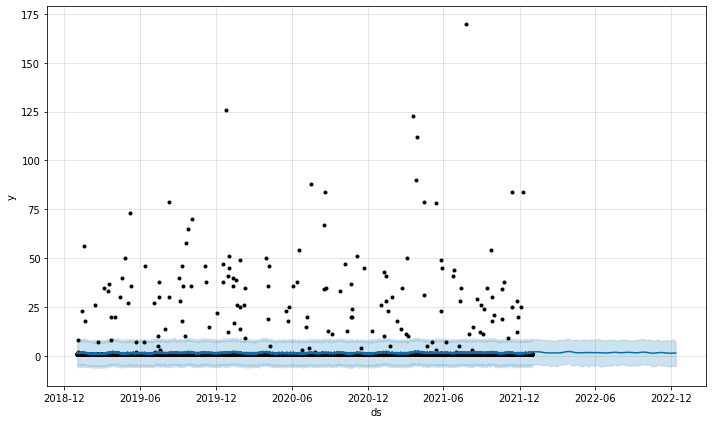

In [118]:
slice_for_zip_code = ts_analysis_df.loc[ts_analysis_df['DeliveryZipCode'] == 60535]
df_deliveries_count = slice_for_zip_code.groupby(['PurchaseDate'])['OrderID'].count().reset_index(name ='Total_Number_of_orders')
df_deliveries_count = df_deliveries_count.rename(columns = {'PurchaseDate': 'ds',
                                'Total_Number_of_orders': 'y'})
 
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=True)
model_prophet.fit(df_deliveries_count) 
future_dates = model_prophet.make_future_dataframe(periods = 50, freq='W')
forecast = model_prophet.predict(future_dates)

model_prophet.plot(forecast);

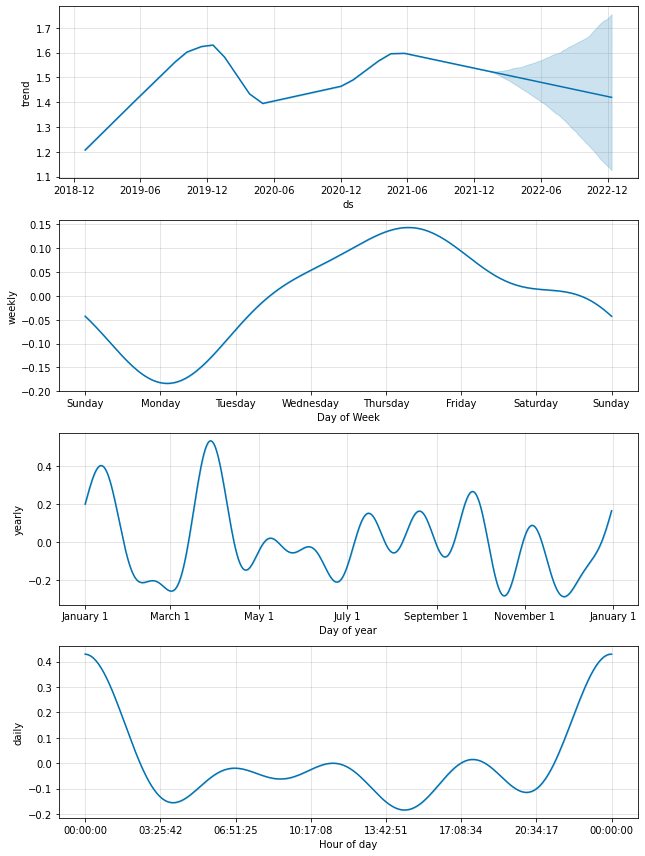

In [119]:
model_prophet.plot_components(forecast);

In [120]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01 07:19:45,1.207362,-5.023435,7.845031,1.207362,1.207362,0.147378,0.147378,0.147378,-0.026030,...,-0.020751,-0.020751,-0.020751,0.194159,0.194159,0.194159,0.0,0.0,0.0,1.354740
1,2019-01-01 10:33:54,1.207558,-5.097897,7.846828,1.207558,1.207558,0.181371,0.181371,0.181371,-0.014589,...,-0.001989,-0.001989,-0.001989,0.197949,0.197949,0.197949,0.0,0.0,0.0,1.388929
2,2019-01-01 11:25:50,1.207611,-5.110574,7.632982,1.207611,1.207611,0.201069,0.201069,0.201069,-0.000496,...,0.002602,0.002602,0.002602,0.198963,0.198963,0.198963,0.0,0.0,0.0,1.408680
3,2019-01-01 11:46:39,1.207632,-5.008460,7.937783,1.207632,1.207632,0.195892,0.195892,0.195892,-0.007869,...,0.004392,0.004392,0.004392,0.199370,0.199370,0.199370,0.0,0.0,0.0,1.403524
4,2019-01-01 12:53:19,1.207699,-5.332075,8.127907,1.207699,1.207699,0.128516,0.128516,0.128516,-0.082093,...,0.009938,0.009938,0.009938,0.200671,0.200671,0.200671,0.0,0.0,0.0,1.336215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10044,2022-11-13 23:30:00,1.428648,-4.893257,7.942328,1.167279,1.721455,0.201323,0.201323,0.201323,0.406643,...,-0.181363,-0.181363,-0.181363,-0.023957,-0.023957,-0.023957,0.0,0.0,0.0,1.629971
10045,2022-11-20 23:30:00,1.426453,-5.007506,8.167691,1.157163,1.729820,0.019776,0.019776,0.019776,0.406643,...,-0.181363,-0.181363,-0.181363,-0.205504,-0.205504,-0.205504,0.0,0.0,0.0,1.446229
10046,2022-11-27 23:30:00,1.424258,-5.497100,7.738145,1.147348,1.734791,-0.063207,-0.063207,-0.063207,0.406643,...,-0.181363,-0.181363,-0.181363,-0.288488,-0.288488,-0.288488,0.0,0.0,0.0,1.361050
10047,2022-12-04 23:30:00,1.422063,-4.997828,8.459794,1.137797,1.743781,-0.017399,-0.017399,-0.017399,0.406643,...,-0.181363,-0.181363,-0.181363,-0.242679,-0.242679,-0.242679,0.0,0.0,0.0,1.404664


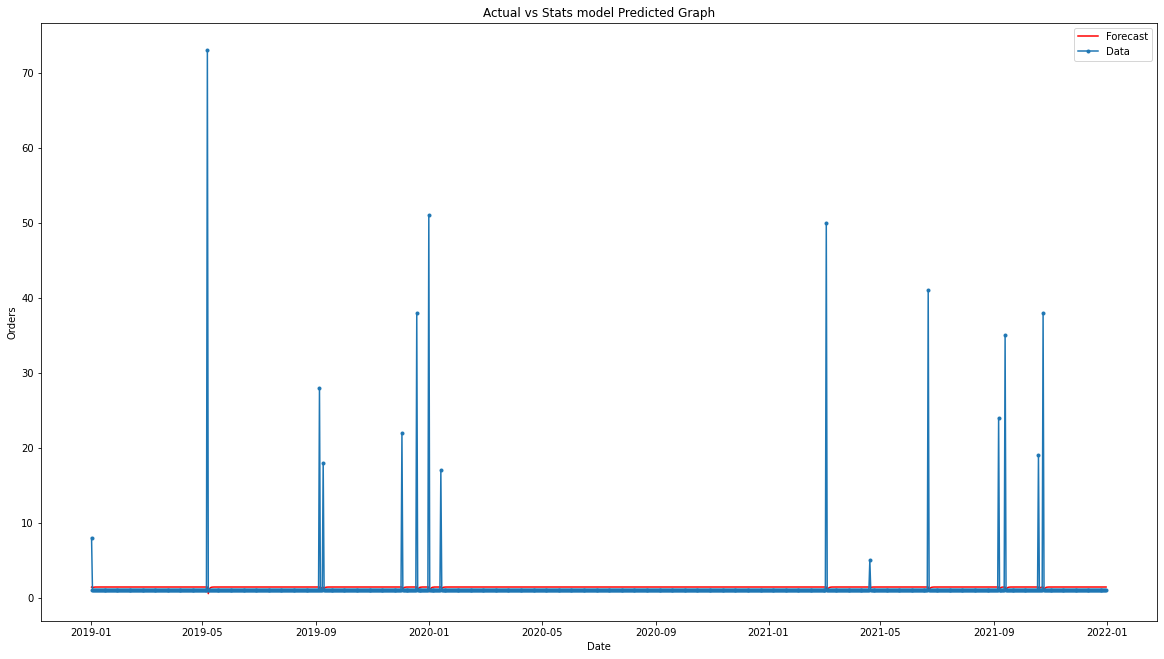

In [121]:
lzip = lambda *x:list(zip(*x))

days = df_deliveries_count.groupby('ds')['ds'].value_counts()
Y = df_deliveries_count['y'].values
X = lzip(*days.index.values)[0]
firstDay = min(X)

# To achieve data consistancy with both actual data and predicted values, I'm adding zeros to dates that do not have orders 
Ys = [0,]*((max(X) - firstDay).days + 1)#[firstDay + timedelta(days=day) for day in range((max(X) - firstDay).days + 1)]
days = pd.Series([firstDay + timedelta(days=i) for i in range(len(Ys))])
for x, y in zip(X, Y):
    Ys[(x - firstDay).days] = y
# parameters of the stats model is based on the below two graphs
est = sm.tsa.ARIMA(Ys, order=(1,0,1)).fit()
yHat = est.fittedvalues
 
fig, axs = plt.subplots(1, 1, figsize=(20, 11))
X = mdates.date2num(days)
axs.plot(X, yHat, c='red', label='Forecast')
axs.plot(X, Ys, marker='.', label='Data')
locator = mdates.AutoDateLocator()
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
axs.legend()
axs.set_title('Actual vs Stats model Predicted Graph')
axs.set_xlabel('Date')
axs.set_ylabel('Orders')
plt.show()

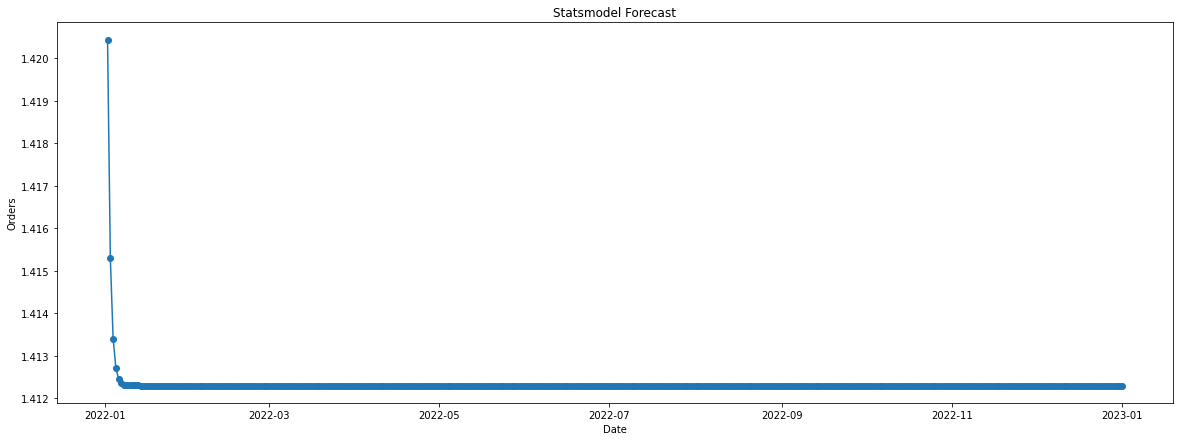

In [123]:
# Plotting the forecast:
lastDay = max(df_deliveries_count['ds'])
X = [lastDay + timedelta(days=i) for i in range(1, 365 + 1)]
weekday = pd.Series([x.weekday() for x in X])
X = mdates.date2num(X)
# Predict orders for future dates:
pred_fd = est.forecast(steps=365)
Y = pred_fd

fig, axs = plt.subplots(1, 1, figsize=(20, 7))
axs.plot(X, Y, marker='o', label='Forecast')
locator = mdates.AutoDateLocator()
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
axs.set_title('Statsmodel Forecast')
axs.set_xlabel('Date')
axs.set_ylabel('Orders')
plt.show()

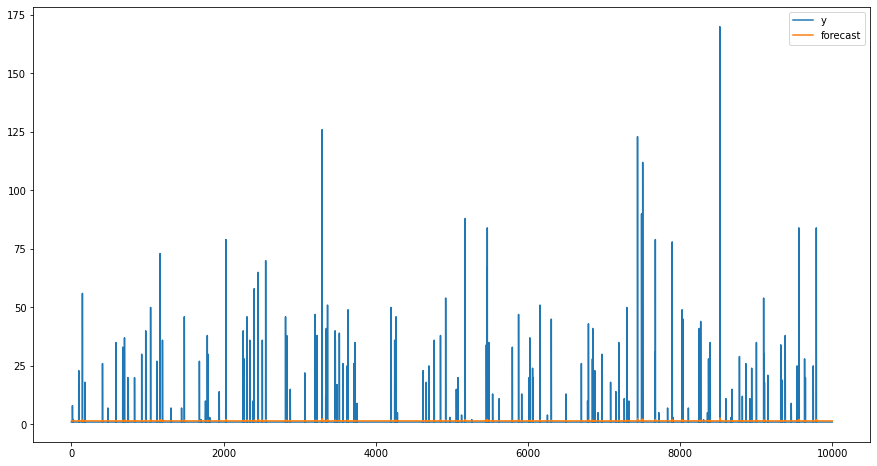

In [124]:
df_stats_model = df_deliveries_count
model = sm.tsa.ARIMA(df_stats_model['y'].iloc[1:], order = (1,0,1))
results = model.fit()
df_stats_model['forecast'] = results.fittedvalues
df_stats_model[['y', 'forecast']].plot(figsize=(15,8))

In [125]:
future = model_prophet.make_future_dataframe(periods=365)
forecast = model_prophet.predict(future)

dailiy sales revenue:

In [126]:
forecast[['ds', 'yhat']].sort_values('yhat', ascending=False)

,ds,yhat
7543,2021-04-01 00:02:46,2.646561
7542,2021-03-31 23:28:19,2.620186
7477,2021-03-25 00:34:48,2.594870
7553,2021-04-01 23:52:23,2.583531
10087,2022-03-30 23:30:00,2.561335
...,...,...
510,2019-02-24 14:33:31,0.723868
563,2019-03-03 14:56:50,0.717165
514,2019-02-25 03:43:59,0.715801
516,2019-02-25 04:13:19,0.713984
